<a href="https://colab.research.google.com/github/danielazenkot/Big-Data-Project/blob/main/Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [ ]:
!pip install shap
!pip install lightgbm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
classification_df = pd.read_csv('/content/drive/MyDrive/BigDataProject/ClassificationData.csv')

In [ ]:
#directory = r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים'
#classification_df = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\ClassificationData.csv")

In [ ]:
print(classification_df.shape)
# Filter columns with more than 0 missing values
columns_with_missing_values = classification_df.columns[classification_df.isna().sum() > 0]

# Print the sum of missing values for selected columns
print(classification_df[columns_with_missing_values].isna().sum())
print(classification_df.head())

(700374, 132)
rain_amount_30_std      94
TD_30_std               94
RH_30_std               94
rain_amount_60_std      57
TD_60_std               57
RH_60_std               57
rain_amount_120_std     33
TD_120_std              33
RH_120_std              33
rain_amount_180_std     17
TD_180_std              17
RH_180_std              17
rain_amount_300_std     10
TD_300_std              10
RH_300_std              10
rain_amount_600_std      3
TD_600_std               3
RH_600_std               3
rain_amount_1200_std     1
TD_1200_std              1
RH_1200_std              1
dtype: int64
   rain_amount_30_mean  rain_amount_30_median  rain_amount_30_std  \
0             0.033333                    0.0            0.057735   
1             0.033333                    0.0            0.057735   
2             0.033333                    0.0            0.057735   
3             0.000000                    0.0            0.000000   
4             0.000000                    0.0            0.00

In [ ]:
print(classification_df.shape)
classification_df.dropna(inplace=True)
print(classification_df.shape)

(700374, 132)
(700280, 132)


In [ ]:
def hidro_station_name(station_code):
    if station_code == 23160:
        return "GERAR - RE'IM"
    if station_code == 23150:
        return "BESOR - REIM"
    return "BESOR - NEW NIZZANA ROAD"
classification_df['hidro_station_name'] = classification_df['hidro_station'].apply(hidro_station_name)

In [ ]:
flood_df = classification_df[classification_df['flood'] == 1]
no_flood_df = classification_df[classification_df['flood'] == 0]

print(flood_df.shape)
print(no_flood_df.shape)
print(f"The ratio flood samples against non flood samples is: {float(flood_df.shape[0]) / float(no_flood_df.shape[0])}")

(62842, 134)
(637438, 134)
The ratio flood samples against non flood samples is: 0.09858527417568454


In [ ]:
classification_df['rain_station'].drop_duplicates()

0         Beer sheva
210786         Dorot
341436    Besor Farm
464291         Lahav
542324    Sede Boqer
Name: rain_station, dtype: object

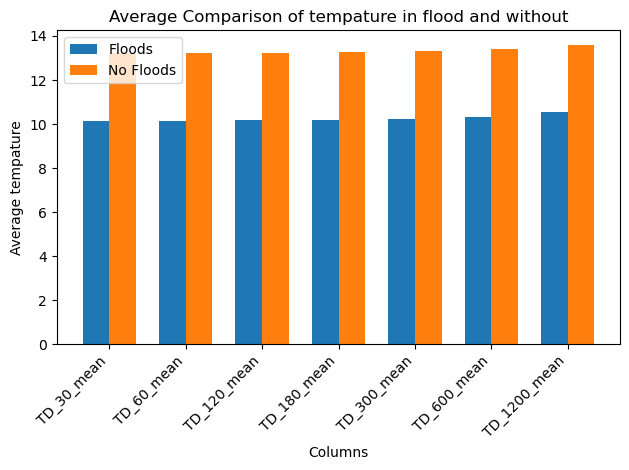

In [ ]:
td_columns_means_floods = {}
td_columns_means_no_floods= {}

for column in flood_df.columns:
    if 'TD' in column and 'mean' in column:
        td_columns_means_floods[column] = flood_df[column].mean()

for column in no_flood_df.columns:
    if 'TD' in column and 'mean' in column:
        td_columns_means_no_floods[column] = no_flood_df[column].mean()

# Plot means side by side on a bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(td_columns_means_no_floods))

bar1 = ax.bar(index, td_columns_means_floods.values(), bar_width, label='Floods')
bar2 = ax.bar([i + bar_width for i in index], td_columns_means_no_floods.values(), bar_width, label='No Floods')

ax.set_xlabel('Columns')
ax.set_ylabel('Average tempature')
ax.set_title('Average Comparison of tempature in flood and without')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(td_columns_means_floods.keys(), rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

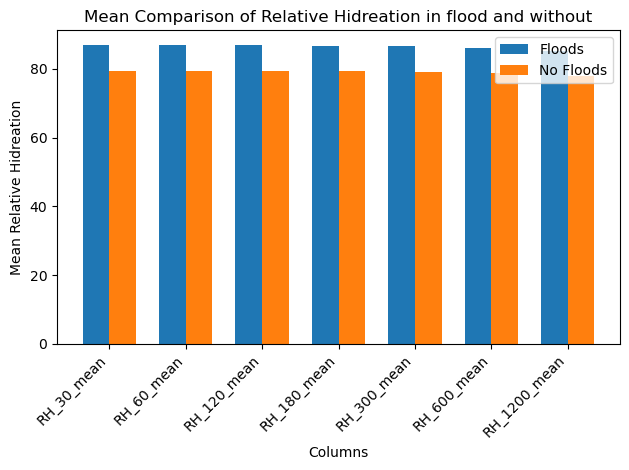

{'TD_30_mean': 10.155086035878341,
 'TD_60_mean': 10.161697909041724,
 'TD_120_mean': 10.176565985846084,
 'TD_180_mean': 10.193051255244427,
 'TD_300_mean': 10.230192059548315,
 'TD_600_mean': 10.331425368624174,
 'TD_1200_mean': 10.528878798422983}

In [ ]:
rh_columns_means_floods = {}
rh_columns_means_no_floods= {}

for column in flood_df.columns:
    if 'RH' in column and 'mean' in column:
        rh_columns_means_floods[column] = flood_df[column].mean()

for column in no_flood_df.columns:
    if 'RH' in column and 'mean' in column:
        rh_columns_means_no_floods[column] = no_flood_df[column].mean()


# Plot means side by side on a bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(rh_columns_means_floods))

bar1 = ax.bar(index, rh_columns_means_floods.values(), bar_width, label='Floods')
bar2 = ax.bar([i + bar_width for i in index], rh_columns_means_no_floods.values(), bar_width, label='No Floods')

ax.set_xlabel('Columns')
ax.set_ylabel('Mean Relative Hidreation')
ax.set_title('Mean Comparison of Relative Hidreation in flood and without')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(rh_columns_means_floods.keys(), rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


td_columns_means_floods

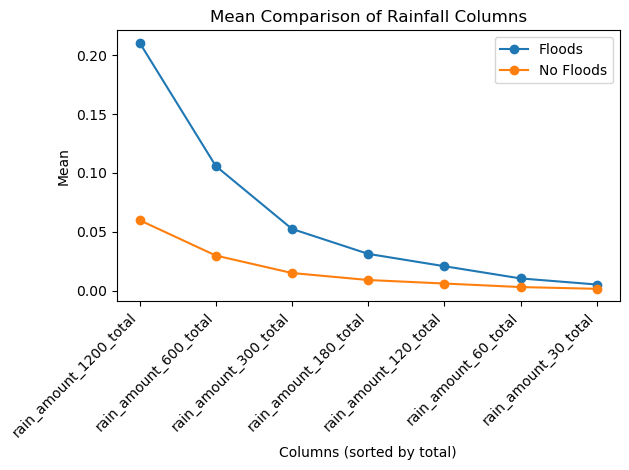

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming flood_df and no_flood_df are already defined
# If not, they should be initialized here

time_intervals = {
    'rain_amount_600_mean': 60,
    'rain_amount_1200_mean': 120,
    'rain_amount_300_mean': 30,
    'rain_amount_180_mean': 18,
    'rain_amount_120_mean': 12,
    'rain_amount_30_mean': 3,
    'rain_amount_60_mean': 6
}

rain_mean_columns_means_floods = {}
rain_mean_columns_means_no_floods = {}

for column in flood_df.columns:
    if 'rain_amount' in column and 'mean' in column:
        rain_mean_columns_means_floods[column] = flood_df[column].mean() * (time_intervals[column] / 60)

for column in no_flood_df.columns:
    if 'rain_amount' in column and 'mean' in column:
        rain_mean_columns_means_no_floods[column] = no_flood_df[column].mean() * (time_intervals[column] / 60)

# Ensure the same order of columns for both DataFrames
columns_order = sorted(rain_mean_columns_means_floods.keys(), key=lambda x: rain_mean_columns_means_floods[x], reverse=True)

# Modify column labels for the plot
columns_order_modified = [col.replace('_mean', '_total') for col in columns_order]

# Plot means as a line plot
fig, ax = plt.subplots()
index = range(len(columns_order))

# Plot DataFrame 1
ax.plot(index, [rain_mean_columns_means_floods[column] for column in columns_order], label='Floods', marker='o')

# Plot DataFrame 2
ax.plot(index, [rain_mean_columns_means_no_floods[column] for column in columns_order], label='No Floods', marker='o')

ax.set_xlabel('Columns (sorted by total)')
ax.set_ylabel('Mean')
ax.set_title('Mean Comparison of Rainfall Columns')
ax.set_xticks(index)
ax.set_xticklabels(columns_order_modified, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
classification_df.head()

,rain_amount_30_mean,rain_amount_30_median,rain_amount_30_std,rain_amount_30_max,rain_amount_30_min,rain_amount_30_EMA,TD_30_mean,TD_30_median,TD_30_std,TD_30_max,...,RH_1200_max,RH_1200_min,RH_1200_EMA,rain_station,rain_date,hidro_station,interval,distance,flood,hidro_station_name
0,0.033333,0.0,0.057735,0.1,0.0,0.006452,15.566667,15.5,0.208167,15.8,...,83.0,39.0,66.190229,Beer sheva,2001-10-22 05:00:00,23160,0 days 18:00:00,70,0,GERAR - RE'IM
1,0.033333,0.0,0.057735,0.1,0.0,0.006035,15.800000,15.8,0.300000,16.1,...,86.0,39.0,66.223218,Beer sheva,2001-10-22 05:10:00,23160,0 days 18:00:00,70,0,GERAR - RE'IM
2,0.033333,0.0,0.057735,0.1,0.0,0.005646,16.033333,16.1,0.208167,16.2,...,86.0,39.0,66.256152,Beer sheva,2001-10-22 05:20:00,23160,0 days 18:00:00,70,0,GERAR - RE'IM
3,0.000000,0.0,0.000000,0.0,0.0,0.005282,16.133333,16.1,0.057735,16.2,...,86.0,39.0,66.284035,Beer sheva,2001-10-22 05:30:00,23160,0 days 18:00:00,70,0,GERAR - RE'IM
4,0.000000,0.0,0.000000,0.0,0.0,0.004941,16.033333,16.1,0.208167,16.2,...,86.0,39.0,66.311872,Beer sheva,2001-10-22 05:40:00,23160,0 days 18:00:00,70,0,GERAR - RE'IM


In [ ]:
def hidro_station_code(row):
    if row['hidro_station_name'] == 'BESOR - REIM':
        return 23150
    if row['hidro_station_name'] == "GERAR - RE'IM":
        return 23160
    if row['hidro_station_name'] == "BESOR - NEW NIZZANA ROAD":
        return 23105

classification_df['hidro_station_code'] = classification_df.apply(hidro_station_code, axis=1)

In [ ]:
!pip install shap

In [ ]:
!pip install lightgbm

In [ ]:
rain_to_station_df = pd.DataFrame({
    'rain_station': ['Besor Farm', 'Dorot', 'Sede Boqer',
                     'Sede Boqer', 'Beer sheva',
                     'Beer sheva', 'Lahav'],
    'hidro_station': [23150, 23160, 23105, 23150,
                        23150, 23160, 23160],
    'hidro_station_name': ["BESOR - REIM", "GERAR - RE'IM", "BESOR - NEW NIZZANA ROAD",
                          "BESOR - REIM", "BESOR - REIM", "GERAR - RE'IM","GERAR - RE'IM"]})

In [ ]:
rain_to_station_df[['hidro_station', 'hidro_station_name']].drop_duplicates()

,hidro_station,hidro_station_name
0,23150,BESOR - REIM
1,23160,GERAR - RE'IM
2,23105,BESOR - NEW NIZZANA ROAD


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def save_confusion_matrix(y_true, y_pred, station_name, river_name,model_name
                          #, output_dir = r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\confusion matrix plots'
                          ):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    filename = f'confusion_matrix_{station_name}_{river_name}_{model_name}'
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    # Check if the output directory exists, if not, create it
    #if not os.path.exists(output_dir):
    #    os.makedirs(output_dir)

    # Save the plot as an image in the output directory
    #plt.savefig(os.path.join(output_dir, filename))
    plt.close()  # Close the plot to release memory

In [ ]:
import pickle

def save_models(trained_models, output_dir):
     # Check if the output directory exists, if not, create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for model_name, model_instance in trained_models:
        # Define the filename based on the model name
        filename = f"{model_name}.pkl"

        # Combine the save directory and filename
        filepath = os.path.join(output_dir, filename)  # Use os.path.join to concatenate directory and filename

        # Open the file in binary write mode
        with open(filepath, 'wb') as file:
            # Use pickle to dump the model instance into the file
            pickle.dump(model_instance, file)

In [ ]:
def load_model(filepath):
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
    return model

In [ ]:
import shap
import pickle
import os

def save_shap_values(X_train,  model_name, model
                     #, output_dir=r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\shap plots'
                     ):
    # Create a SHAP explainer object for the model
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_train)

    # Handle LightGBM output for binary classification
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]  # Use the SHAP values for the positive class

    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap_values = pd.DataFrame(abs(shap_values).mean(axis=0), index=X_train.columns, columns=['mean_abs_shap'])

    # Sort features by mean absolute SHAP values and select top 20
    top_20_features = mean_abs_shap_values.sort_values(by='mean_abs_shap', ascending=False).head(20)

    # Extract the names of the top 20 features
    top_20_feature_names = top_20_features.index

    # Plot SHAP summary plot for the top 20 features
    plt.figure()  # Create a new figure
    shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=20, show=False)

    # Define the filename for saving the plot
    filename = f"shap_summary_plot_{model_name}.png"

    # Check if the output directory exists, if not, create it
    #if not os.path.exists(output_dir):
    #    os.makedirs(output_dir)

    # Save the plot as an image in the output directory
    #plt.savefig(os.path.join(output_dir, filename))
    plt.close()  # Close the plot to release memory

ModuleNotFoundError: No module named 'shap'

Ran on local computer

In [ ]:
'''
file_path = r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_time_series_no_cv\Beer sheva_23150_XGBoost.pkl'

# Open the file in read-binary mode and load the model
with open(file_path, 'rb') as f:
    model = pickle.load(f)
data = classification_df[(classification_df['rain_station'] == 'Beer sheva') &
                                            (classification_df['hidro_station'] == 23150)]

print(data.shape)

# Convert rain_date to datetime format
data['rain_date'] = pd.to_datetime(data['rain_date'])

# Split data into past (prior to 2016) and future (2016 and beyond)
df_past = data[data['rain_date'] < '2016-01-01']
df_future = data[data['rain_date'] >= '2016-01-01']

# Identify minority class instances
minority_class = df_past[df_past['flood'] == 1]

# Upsample minority class
upsampled_minority = resample(minority_class,
                              replace=True,     # Sample with replacement
                              n_samples=len(df_past[df_past['flood'] == 0]),  # Match majority class
                              random_state=42)  # For reproducibility

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_past[df_past['flood'] == 0], upsampled_minority])

# Shuffle the upsampled data
df_upsampled = df_upsampled.sample(frac=1, random_state=42)

# Separate features and target variable in the upsampled training data
X_train = df_upsampled.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis=1)
y_train = df_upsampled['flood']

X_test = df_future.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis = 1)
y_test = df_future['flood']
# Loop through each .pkl file
save_shap_values(X_train, model_name, model)
'''

(105386, 134)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [ ]:
def plot_model_results_F1(results_df, filename
                          #, output_dir=r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\model_comparision_vizualiztions'
                          ):
    # Filter the results dataframe by model type
    random_forest_results = results_df[results_df['Model Name'].str.contains('RandomForest')]
    LightGBM_results = results_df[results_df['Model Name'].str.contains('LightGBM')]
    xgboost_results = results_df[results_df['Model Name'].str.contains('XGBoost')]
    random_forest_F1 = [round(row['F1 Score_test'], 2) for i, row in random_forest_results.iterrows()]
    LightGBM_F1 = [round(row['F1 Score_test'], 2) for i, row in LightGBM_results.iterrows()]
    xgboost_F1 = [round(row['F1 Score_test'], 2) for i, row in xgboost_results.iterrows()]
    # station_river_names = ['_'.join(name['Model Name'].split('_')[:-1]) for i, name in xgboost_results.iterrows()]
    station_rain_names = [f"{name['Model Name'].split('_')[0]}_{name['Model Name'].split('_')[1]}"  for _, name in xgboost_results.iterrows()]

    # station_river_names = list(set(station_river_names))


    data = {
        'Station_rain': station_rain_names,
        'F1 RandomForest': random_forest_F1,
        'F1 lgbm': LightGBM_F1,
        'F1 XGboost': xgboost_F1
    }

    # Use Seaborn's dark color palette
    sns.set_palette("dark")

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, metric in enumerate(['F1 RandomForest', 'F1 lgbm', 'F1 XGboost']):
        bars = ax.bar(
            [x + i * 0.2 for x in range(len(data['Station_rain']))],
            data[metric],
            width=0.2,
            label=metric
        )
        for bar in bars:
            if metric == 'F1 XGboost':
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.01,  # Adjust the vertical position for the text
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=9,  # Adjust the font size
                    weight='bold'  # Make the text bold
                )

    ax.set_xlabel('Station & River', weight='bold')  # Make the xlabel bold
    ax.set_ylabel('Scores', weight='bold')  # Make the ylabel bold
    # ax.set_title('Inference Scores for Adults Dataset by Number of Missing Features', weight='bold')  # Make the title bold

    # Set custom x-axis labels
    ax.set_xticks([x + 0.4 for x in range(len(data['Station_rain']))])
    ax.set_xticklabels(station_rain_names, rotation=90, ha='right')

    # Adjust the legend position
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Check if the output directory exists, if not, create it
    #if not os.path.exists(output_dir):
    #    os.makedirs(output_dir)

    # Save the plot as an image in the output directory
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, filename))
    plt.close()  # Close the plot to release memory

In [ ]:
def plot_model_results_ROC_AUC(results_df,  filename
                               #, output_dir=r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\model_comparision_vizualiztions'
                               ):
    # Filter the results dataframe by model type
    random_forest_results = results_df[results_df['Model Name'].str.contains('RandomForest')]
    LightGBM_results = results_df[results_df['Model Name'].str.contains('LightGBM')]
    xgboost_results = results_df[results_df['Model Name'].str.contains('XGBoost')]
    random_forest_F1 = [round(row['ROC_AUC_test'], 2) for i, row in random_forest_results.iterrows()]
    LightGBM_F1 = [round(row['ROC_AUC_test'], 2) for i, row in LightGBM_results.iterrows()]
    xgboost_F1 = [round(row['ROC_AUC_test'], 2) for i, row in xgboost_results.iterrows()]
    # station_river_names = ['_'.join(name['Model Name'].split('_')[:-1]) for i, name in xgboost_results.iterrows()]
    station_rain_names = [f"{name['Model Name'].split('_')[0]}_{name['Model Name'].split('_')[1]}"  for _, name in xgboost_results.iterrows()]

    # station_river_names = list(set(station_river_names))


    data = {
        'Station_rain': station_rain_names,
        'ROC_AUC RandomForest': random_forest_F1,
        'ROC_AUC lgbm': LightGBM_F1,
        'ROC_AUC XGboost': xgboost_F1
    }

    # Use Seaborn's dark color palette
    sns.set_palette("dark")

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, metric in enumerate(['ROC_AUC RandomForest', 'ROC_AUC lgbm', 'ROC_AUC XGboost']):
        bars = ax.bar(
            [x + i * 0.2 for x in range(len(data['Station_rain']))],
            data[metric],
            width=0.2,
            label=metric
        )
        for bar in bars:
            if metric == 'F1 XGboost':
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.01,  # Adjust the vertical position for the text
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=9,  # Adjust the font size
                    weight='bold'  # Make the text bold
                )

    ax.set_xlabel('Station & River', weight='bold')  # Make the xlabel bold
    ax.set_ylabel('Scores', weight='bold')  # Make the ylabel bold
    # ax.set_title('Inference Scores for Adults Dataset by Number of Missing Features', weight='bold')  # Make the title bold

    # Set custom x-axis labels
    ax.set_xticks([x + 0.4 for x in range(len(data['Station_rain']))])
    ax.set_xticklabels(station_rain_names, rotation=90, ha='right')

    # Adjust the legend position
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    #if not os.path.exists(output_dir):
    #    os.makedirs(output_dir)

    # Save the plot as an image in the output directory
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, filename))
    plt.close()  # Close the plot to release memory

In [ ]:
def plot_model_average_results_ROC_AUC(results_df,  filename
                                       #, output_dir=r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\model_comparision_vizualiztions'
                                       ):
    # Filter the results dataframe by model type
    random_forest_results = results_df[results_df['Model Name'].str.contains('RandomForest')]
    lightgbm_results = results_df[results_df['Model Name'].str.contains('LightGBM')]
    xgboost_results = results_df[results_df['Model Name'].str.contains('XGBoost')]

    # Calculate the average ROC_AUC scores for each model
    avg_random_forest_ROC_AUC = random_forest_results['ROC_AUC_test'].mean()
    avg_lightgbm_ROC_AUC = lightgbm_results['ROC_AUC_test'].mean()
    avg_xgboost_ROC_AUC = xgboost_results['ROC_AUC_test'].mean()

    # Prepare the data for plotting
    models = ['RandomForest', 'LightGBM', 'XGBoost']
    avg_scores = [avg_random_forest_ROC_AUC, avg_lightgbm_ROC_AUC, avg_xgboost_ROC_AUC]

    data = {
        'Model': models,
        'Average ROC_AUC': avg_scores
    }

    # Create a DataFrame for easy plotting
    avg_scores_df = pd.DataFrame(data)

    # Use Seaborn's dark color palette
    sns.set_palette("dark")

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the average scores
    bars = ax.bar(avg_scores_df['Model'], avg_scores_df['Average ROC_AUC'], width=0.5)

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,  # Adjust the vertical position for the text
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9,  # Adjust the font size
            weight='bold'  # Make the text bold
        )

    ax.set_xlabel('Model', weight='bold')  # Make the xlabel bold
    ax.set_ylabel('Average ROC_AUC Score', weight='bold')  # Make the ylabel bold
    ax.set_title('Average ROC_AUC Scores by Model', weight='bold')  # Make the title bold

    #if not os.path.exists(output_dir):
    #    os.makedirs(output_dir)

    # Save the plot as an image in the output directory
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, filename))
    plt.close()  # Close the plot to release memory

In [ ]:
def plot_model_average_results_F1_Score(results_df,  filename,
                                        #output_dir=r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\model_comparision_vizualiztions'
                                        ):
    # Filter the results dataframe by model type
    random_forest_results = results_df[results_df['Model Name'].str.contains('RandomForest')]
    lightgbm_results = results_df[results_df['Model Name'].str.contains('LightGBM')]
    xgboost_results = results_df[results_df['Model Name'].str.contains('XGBoost')]

    # Calculate the average ROC_AUC scores for each model
    avg_random_forest_ROC_AUC = random_forest_results['F1 Score_test'].mean()
    avg_lightgbm_ROC_AUC = lightgbm_results['F1 Score_test'].mean()
    avg_xgboost_ROC_AUC = xgboost_results['F1 Score_test'].mean()

    # Prepare the data for plotting
    models = ['RandomForest', 'LightGBM', 'XGBoost']
    avg_scores = [avg_random_forest_ROC_AUC, avg_lightgbm_ROC_AUC, avg_xgboost_ROC_AUC]

    data = {
        'Model': models,
        'Average F1 score': avg_scores
    }

    # Create a DataFrame for easy plotting
    avg_scores_df = pd.DataFrame(data)

    # Use Seaborn's dark color palette
    sns.set_palette("dark")

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the average scores
    bars = ax.bar(avg_scores_df['Model'], avg_scores_df['Average F1 score'], width=0.5)

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,  # Adjust the vertical position for the text
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9,  # Adjust the font size
            weight='bold'  # Make the text bold
        )

    ax.set_xlabel('Model', weight='bold')  # Make the xlabel bold
    ax.set_ylabel('Average F1 Scores Score', weight='bold')  # Make the ylabel bold
    ax.set_title('Average F1 Scores by Model', weight='bold')  # Make the title bold

    #if not os.path.exists(output_dir):
    #    os.makedirs(output_dir)

    # Save the plot as an image in the output directory
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, filename))
    plt.close()  # Close the plot to release memory

The same method as the previos project, not a good way to messure!

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.utils import resample

results_df_no_time_series = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'])
models_df_no_time_series= pd.DataFrame(columns = ['Rain Station', 'Hidro Station', 'F1-Score' ,'model'])
trained_models_no_time_series = []

for index, row in rain_to_station_df.iterrows():

    data = classification_df[(classification_df['rain_station'] == row['rain_station']) &
                                            (classification_df['hidro_station'] == row['hidro_station'])]
     # Separate the majority and minority classes
    majority_class = data[data['flood'] == 0]
    minority_class = data[data['flood'] == 1]  # Assuming '1' represents the minority class

    # Resample the minority class to match the number of samples in the majority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

    # Combine the upsampled minority class with the majority class
    balanced_data = pd.concat([majority_class, minority_upsampled])

    # Separate the features (X) and target (y) from the balanced dataset
    X_balanced = balanced_data.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis = 1)
    y_balanced = balanced_data['flood']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=42)

    print(len(y_test), sum(y_test), sum(y_test)/len(y_test))
    print(len(y_train), sum(y_train), sum(y_train)/len(y_train))

    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        # joblib.dump(model, model_file_name)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        classification_report_str = classification_report(y_test, y_pred, output_dict=True)

        new_results = pd.DataFrame({
            'Model Name': [f"{row['rain_station']}_{row['hidro_station_name']}_{model_name}"],
            'Accuracy': [accuracy],
            'Precision': [classification_report_str['weighted avg']['precision']],
            'Recall': [classification_report_str['weighted avg']['recall']],
            'F1 Score': [classification_report_str['weighted avg']['f1-score']],
            'ROC_AUC': [roc_auc]
        })

        results_df_no_time_series = pd.concat([results_df_no_time_series, new_results], ignore_index=True)

        new_best_models = pd.DataFrame( {
        'Rain Station': [row['rain_station']],
        'Hidro Station': [row['hidro_station']],
        'F1-Score': [classification_report_str['weighted avg']['f1-score']],
        'model': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"]
        }
        )
        models_df_no_time_series = pd.concat([models_df_no_time_series,new_best_models])
        output_dir = r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\confusion matrix plots no time series'
        save_confusion_matrix(y_test, y_pred, row['rain_station'], row['hidro_station_name'], model_name, output_dir)

        trained_models_no_time_series.append((f"{row['rain_station']}_{row['hidro_station']}_{model_name}", model))

# Save the results dataframe to a CSV file
results_df_no_time_series.to_csv(r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_no_time_series.csv', index=False)
save_models(trained_models_no_time_series, r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_no_time_series')

93262 46858 0.5024340031309644
139892 69719 0.4983773196465845
[LightGBM] [Info] Number of positive: 69719, number of negative: 70173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24157
[LightGBM] [Info] Number of data points in the train set: 139892, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498377 -> initscore=-0.006491
[LightGBM] [Info] Start training from score -0.006491
91949 46124 0.5016259013148593
137923 68812 0.4989160618606034
[LightGBM] [Info] Number of positive: 68812, number of negative: 69111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24305
[LightGBM] [Info] Number of data points in the train set: 137923, number of used features: 124
[LightGBM] [In

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\User\\Desktop\\פרוייקט כריית מידע במאגרים גדולים\\classification_results_no_time_series.csv'

In [ ]:
results_df_no_time_series.iloc[0:30]

,Model Name,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,Besor Farm_BESOR - REIM_RandomForest,0.999807,0.999807,0.999807,0.999807,0.999806
1,Besor Farm_BESOR - REIM_LightGBM,0.998853,0.998854,0.998853,0.998853,0.998848
2,Besor Farm_BESOR - REIM_XGBoost,0.999700,0.999700,0.999700,0.999700,0.999698
3,Dorot_GERAR - RE'IM_RandomForest,0.999402,0.999402,0.999402,0.999402,0.999401
4,Dorot_GERAR - RE'IM_LightGBM,0.991082,0.991135,0.991082,0.991082,0.991065
5,Dorot_GERAR - RE'IM_XGBoost,0.999163,0.999163,0.999163,0.999163,0.999160
6,Sede Boqer_BESOR - NEW NIZZANA ROAD_RandomForest,0.999771,0.999771,0.999771,0.999771,0.999771
7,Sede Boqer_BESOR - NEW NIZZANA ROAD_LightGBM,0.999476,0.999477,0.999476,0.999476,0.999476
8,Sede Boqer_BESOR - NEW NIZZANA ROAD_XGBoost,0.999689,0.999689,0.999689,0.999689,0.999689
9,Sede Boqer_BESOR - REIM_RandomForest,0.999590,0.999591,0.999590,0.999590,0.999591


In [ ]:
#save_models(trained_models_no_time_series, r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_no_time_series')

In [ ]:
#file = r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_no_time_series\Beer sheva_23150_LightGBM.pkl'
#loaded_model = load_model(file)
#loaded_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
data = classification_df[(classification_df['rain_station'] == 'Beer sheva') &
                                        (classification_df['hidro_station'] == 23150)]

# Convert rain_date to datetime format
data['rain_date'] = pd.to_datetime(data['rain_date'])

# Split data into past (prior to 2016) and future (2016 and beyond)
df_past = data[data['rain_date'] < '2016-01-01']
df_future = data[data['rain_date'] >= '2016-01-01']

df_past = df_past.sort_values(by = 'rain_date')
df_future = df_future.sort_values(by = 'rain_date')

# Identify minority class instances
minority_class = df_past[df_past['flood'] == 1]

# Upsample minority class
upsampled_minority = resample(minority_class,
                              replace=True,     # Sample with replacement
                              n_samples=len(df_past[df_past['flood'] == 0]),  # Match majority class
                              random_state=42)  # For reproducibility

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_past[df_past['flood'] == 0], upsampled_minority])

# Shuffle the upsampled data
df_upsampled = df_upsampled.sample(frac=1, random_state=42)

# Separate features and target variable in the upsampled training data
X_train = df_upsampled.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'
                            , 'rain_amount_1200_min', 'distance', 'hidro_station_code'], axis=1)
y_train = df_upsampled['flood']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]
constant_features

['rain_amount_1200_min', 'distance', 'hidro_station_code']

Save feature importence plots

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.model_selection import train_test_split
import os

# Function to plot and save feature importance
def plot_and_save_feature_importance(df, metric, file_name):
    plt.figure(figsize=(10, 8))
    sns.barplot(x=metric, y='Feature', data=df.sort_values(by=metric, ascending=False), palette='viridis')
    plt.title(f'Top 20 Features by {metric}')
    plt.tight_layout()  # Adjust the layout to make room for y-axis labels
    plt.savefig(file_name)
    plt.close()

# Create a folder to save the images if it doesn't exist
#output_folder = r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\feature_importance_plots"
#if not os.path.exists(output_folder):
#    os.makedirs(output_folder)

# For every rain and hidro station find the best model
for index, row in rain_to_station_df.iterrows():
    data = classification_df[(classification_df['rain_station'] == row['rain_station']) &
                                            (classification_df['hidro_station'] == row['hidro_station'])]
    X = data.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'
                            , 'rain_amount_1200_min', 'distance', 'hidro_station_code'], axis = 1)
    y = data['flood']

    # Assuming you have your features in X and target in y

    # Label encode the target variable if it is categorical
    y_encoded = LabelEncoder().fit_transform(y)

    # Standardize continuous features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Calculate mutual information for each feature
    mutual_info = mutual_info_classif(X, y_encoded)

    # Calculate ANOVA F-Value for each feature
    f_values, p_values = f_classif(X_scaled, y_encoded)

    # Create a DataFrame to store the feature scores
    feature_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'Mutual_Info': mutual_info,
        'F_Value': f_values
    })

    # Sort by the most important features according to each metric
    top_features_mutual_info = feature_scores.nlargest(20, 'Mutual_Info')
    top_features_f_value = feature_scores.nlargest(20, 'F_Value')

    # Generate filenames
    base_filename = f"{row['rain_station']}_{row['hidro_station']}_"
    mutual_info_filename = os.path.join(output_folder, f"{base_filename}Mutual_Info.png")
    f_value_filename = os.path.join(output_folder, f"{base_filename}F_Value.png")

    # Plot and save the top features by each metric
    #plot_and_save_feature_importance(top_features_mutual_info, 'Mutual_Info', mutual_info_filename)
    #plot_and_save_feature_importance(top_features_f_value, 'F_Value', f_value_filename)

Features [94] are constant.
invalid value encountered in divide
Features [94] are constant.
invalid value encountered in divide
Features [94] are constant.
invalid value encountered in divide


In [ ]:
results_df_no_time_series

,Model Name,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,Besor Farm_BESOR - REIM_RandomForest,0.999807,0.999807,0.999807,0.999807,0.999806
1,Besor Farm_BESOR - REIM_LightGBM,0.998853,0.998854,0.998853,0.998853,0.998848
2,Besor Farm_BESOR - REIM_XGBoost,0.999700,0.999700,0.999700,0.999700,0.999698
3,Dorot_GERAR - RE'IM_RandomForest,0.999402,0.999402,0.999402,0.999402,0.999401
4,Dorot_GERAR - RE'IM_LightGBM,0.991082,0.991135,0.991082,0.991082,0.991065
5,Dorot_GERAR - RE'IM_XGBoost,0.999163,0.999163,0.999163,0.999163,0.999160
6,Sede Boqer_BESOR - NEW NIZZANA ROAD_RandomForest,0.999771,0.999771,0.999771,0.999771,0.999771
7,Sede Boqer_BESOR - NEW NIZZANA ROAD_LightGBM,0.999476,0.999477,0.999476,0.999476,0.999476
8,Sede Boqer_BESOR - NEW NIZZANA ROAD_XGBoost,0.999689,0.999689,0.999689,0.999689,0.999689
9,Sede Boqer_BESOR - REIM_RandomForest,0.999590,0.999591,0.999590,0.999590,0.999591


In [ ]:
models_df_no_time_series

,Rain Station,Hidro Station,F1-Score,model
0,Besor Farm,23150,0.999807,Besor Farm_23150_RandomForest
0,Besor Farm,23150,0.998853,Besor Farm_23150_LightGBM
0,Besor Farm,23150,0.999700,Besor Farm_23150_XGBoost
0,Dorot,23160,0.999402,Dorot_23160_RandomForest
0,Dorot,23160,0.991082,Dorot_23160_LightGBM
0,Dorot,23160,0.999163,Dorot_23160_XGBoost
0,Sede Boqer,23105,0.999771,Sede Boqer_23105_RandomForest
0,Sede Boqer,23105,0.999476,Sede Boqer_23105_LightGBM
0,Sede Boqer,23105,0.999689,Sede Boqer_23105_XGBoost
0,Sede Boqer,23150,0.999590,Sede Boqer_23150_RandomForest


In [ ]:
results_df_time_series_no_cv

,Model Name,Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC_AUC_train,Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC_AUC_test,flood_no_flood_rate,Rain Station,Hidro Station
0,Besor Farm_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.952134,0.946483,0.952134,0.938391,0.602509,0.057166,Besor Farm,23150
1,Besor Farm_23150_LightGBM,0.999825,0.999825,0.999825,0.999825,0.999825,0.948991,0.938686,0.948991,0.940405,0.641059,0.057166,Besor Farm,23150
2,Besor Farm_23150_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.949223,0.938775,0.949223,0.940109,0.636314,0.057166,Besor Farm,23150
3,Dorot_23160_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.856043,0.859740,0.856043,0.811015,0.575316,0.166250,Dorot,23160
4,Dorot_23160_LightGBM,0.998945,0.998947,0.998945,0.998945,0.998945,0.845031,0.817757,0.845031,0.817980,0.605450,0.166250,Dorot,23160
5,Dorot_23160_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.848653,0.823409,0.848653,0.816251,0.595443,0.166250,Dorot,23160
6,Sede Boqer_23105_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.949325,0.951893,0.949325,0.924781,0.501335,0.050811,Sede Boqer,23105
7,Sede Boqer_23105_LightGBM,1.000000,1.000000,1.000000,1.000000,1.000000,0.951530,0.943940,0.951530,0.931444,0.530928,0.050811,Sede Boqer,23105
8,Sede Boqer_23105_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.952479,0.944308,0.952479,0.934339,0.545329,0.050811,Sede Boqer,23105
9,Sede Boqer_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.916559,0.859129,0.916559,0.886835,0.494507,0.072858,Sede Boqer,23150


In [ ]:
# Filter the results dataframe by model type
random_forest_results = results_df[results_df['Model Name'].str.contains('RandomForest')]
LightGBM_results = results_df[results_df['Model Name'].str.contains('LightGBM')]
xgboost_results = results_df[results_df['Model Name'].str.contains('XGBoost')]
random_forest_accuracy = [round(row['Accuracy'], 2) for i, row in random_forest_results.iterrows()]
LightGBM_accuracy = [round(row['Accuracy'], 2) for i, row in LightGBM_results.iterrows()]
xgboost_accuracy = [round(row['Accuracy'], 2) for i, row in xgboost_results.iterrows()]
# station_river_names = ['_'.join(name['Model Name'].split('_')[:-1]) for i, name in xgboost_results.iterrows()]
station_rain_names = [name['Model Name'].split('_')[0] + str(i) for i, name in xgboost_results.iterrows()]

# station_river_names = list(set(station_river_names))


data = {
    'Station_rain': station_river_names,
    'Accuracy RandomForest': random_forest_accuracy,
    'Accuracy lgbm': LightGBM_accuracy,
    'Accuracy XGboost': xgboost_accuracy
}

# Use Seaborn's dark color palette
sns.set_palette("dark")

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(['Accuracy RandomForest', 'Accuracy lgbm', 'Accuracy XGboost']):
    bars = ax.bar(
        [x + i * 0.2 for x in range(len(data['Station_rain']))],
        data[metric],
        width=0.2,
        label=metric
    )
    for bar in bars:
        if metric == 'Accuracy XGboost':
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,  # Adjust the vertical position for the text
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=9,  # Adjust the font size
                weight='bold'  # Make the text bold
            )

ax.set_xlabel('Station & River', weight='bold')  # Make the xlabel bold
ax.set_ylabel('Scores', weight='bold')  # Make the ylabel bold
# ax.set_title('Inference Scores for Adults Dataset by Number of Missing Features', weight='bold')  # Make the title bold

# Set custom x-axis labels
ax.set_xticks([x + 0.4 for x in range(len(data['Station_rain']))])
ax.set_xticklabels(station_river_names, rotation=90, ha='right')

# Adjust the legend position
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

NameError: name 'station_river_names' is not defined

Time series cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


# Define a function to perform grid search
def perform_grid_search(model, param_grid, X_train, y_train, scorer):
    '''
        Preform the param grid on the train set
    '''
    cls = 0
    if model == 'RandomForest':
        cls = RandomForestClassifier()
    if model == 'LightGBM':
        cls = lgb.LGBMClassifier()
    if model == 'XGBoost':
        cls = XGBClassifier()
    print('heyy')
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(estimator=cls, param_grid=param_grid, scoring=scorer, cv=tscv)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

models_list = []

# Initialize dictionaries to store parameters grid for each model type
params_grid = {
    'RandomForest': {
        #'n_estimators': [25, 50],
        #'max_depth': [3, 5, 7],
       # 'min_samples_split': [2, 5, 10],
       # 'min_samples_leaf': [1, 2, 4],
        #'max_features': ['sqrt', 'log2'],
        'random_state': [42]
    },
    'LightGBM': {
        #'num_leaves': [31, 50, 100],
        #'max_depth': [3, 5, 7],
        #'learning_rate': [0.05, 0.1, 0.2],
        #'lambda_l1': [0, 0.1, 1],
       # 'lambda_l2': [0, 0.1, 1],
        #'num_iterations': [25, 50],
        'random_state': [42]
    },
    'XGBoost': {
        #'max_depth': [3, 5, 7],
        #'learning_rate': [0.05, 0.1, 0.2],
        #'reg_alpha': [0, 0.1, 1],
        #'reg_lambda': [0, 0.1, 1],
        #'n_estimators' : [25, 50],
        'random_state': [42]
    }
}

# Initialize empty dictionary to store selected parameters for each iteration
selected_params = {'RandomForest': [], 'LightGBM': [], 'XGBoost': []}

# Save the results
results_df_time_series_cv = pd.DataFrame(columns=['Model Name', 'Accuracy_train', 'Precision_train', 'Recall_train', 'F1 Score_train',
                                   'ROC_AUC_train','Accuracy_test', 'Precision_test', 'Recall_test', 'F1 Score_test',
                                         'ROC_AUC_test','flood_no_flood_rate', 'Rain Station', 'Hidro Station'])

# For each rain and hidro station, save the best results
models_df= pd.DataFrame(columns = ['Rain Station', 'Hidro Station', 'F1-Score' ,'model'])
trained_models_time_series_cv = []

# For every rain and hidro station find the best model
for index, row in rain_to_station_df.iterrows():

    data = classification_df[(classification_df['rain_station'] == row['rain_station']) &
                                            (classification_df['hidro_station'] == row['hidro_station'])]

    # Convert rain_date to datetime format
    data['rain_date'] = pd.to_datetime(data['rain_date'])

    # Split data into past (prior to 2016) and future (2016 and beyond)
    df_past = data[data['rain_date'] < '2016-01-01']
    df_future = data[data['rain_date'] >= '2016-01-01']

    df_past = df_past.sort_values(by = 'rain_date')
    df_future = df_future.sort_values(by = 'rain_date')

    # Identify minority class instances
    minority_class = df_past[df_past['flood'] == 1]

    # Upsample minority class
    upsampled_minority = resample(minority_class,
                                  replace=True,     # Sample with replacement
                                  n_samples=len(df_past[df_past['flood'] == 0]),  # Match majority class
                                  random_state=42)  # For reproducibility

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_past[df_past['flood'] == 0], upsampled_minority])

    # Shuffle the upsampled data
    df_upsampled = df_upsampled.sample(frac=1, random_state=42)

    # Separate features and target variable in the upsampled training data
    X_train = df_upsampled.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis=1)
    y_train = df_upsampled['flood']

    X_test = df_future.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis = 1)
    y_test = df_future['flood']

    for model_name, param_grid in params_grid.items():
        # Define scorer for grid search
        scorer = make_scorer(roc_auc_score)
        print(model_name)
        model = perform_grid_search(model_name, param_grid, X_train, y_train, scorer)
        models_list.append(model)
        print("hello")
        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy_test = accuracy_score(y_test, y_pred)
        accuracy_train = accuracy_score(y_train, model.predict(X_train))

        roc_auc_train = roc_auc_score(y_train, model.predict(X_train))
        roc_auc_test = roc_auc_score(y_test, y_pred)

        classification_report_str_test = classification_report(y_test, y_pred, output_dict=True)
        classification_report_str_train = classification_report(y_train, model.predict(X_train), output_dict=True)

        # Store selected parameters
        selected_params[model_name].append(model.get_params())

        new_results = pd.DataFrame({
            'Model Name': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"],
            'Accuracy_test': [accuracy_test],
            'Precision_test': [classification_report_str_test['weighted avg']['precision']],
            'Recall_test': [classification_report_str_test['weighted avg']['recall']],
            'F1 Score_test': [classification_report_str_test['weighted avg']['f1-score']],
            'ROC_AUC_train': [roc_auc_train],
            'Accuracy_train': [accuracy_train],
            'Precision_train': [classification_report_str_train['weighted avg']['precision']],
            'Recall_train': [classification_report_str_train['weighted avg']['recall']],
            'F1 Score_train': [classification_report_str_train['weighted avg']['f1-score']],
            'ROC_AUC_test': [roc_auc_test],
            'flood_no_flood_rate': sum(y_test)/len(y_test),
            'Rain Station': [row['rain_station']],
            'Hidro Station': [row['hidro_station']]
        })

        results_df_time_series_cv = pd.concat([results_df_time_series_cv, new_results], ignore_index=True)

        new_best_models = pd.DataFrame( {
        'Rain Station': [row['rain_station']],
        'Hidro Station': [row['hidro_station']],
        'F1-Score': [classification_report_str_test['weighted avg']['f1-score']],
        'model': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"]
        }
        )
        models_df = pd.concat([models_df,new_best_models])

        #save_confusion_matrix(y_test, y_pred, row['rain_station'], row['hidro_station_name'], model_name, r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\confusion matrix plots time series grid search")

        trained_models_time_series_cv.append((f"{row['rain_station']}_{row['hidro_station']}_{model_name}", model))

        #save_shap_values(X_train, row['rain_station'], row['hidro_station_name'], model_name, r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\shap values")

#results_df_time_series_cv.to_csv(r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_grid_search.csv', index=False)
#save_models(trained_models_time_series_cv, r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_time_series_cv')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForest
heyy
hello
LightGBM
heyy
[LightGBM] [Info] Number of positive: 13481, number of negative: 13182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23632
[LightGBM] [Info] Number of data points in the train set: 26663, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505607 -> initscore=0.022429
[LightGBM] [Info] Start training from score 0.022429
[LightGBM] [Info] Number of positive: 26745, number of negative: 26577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23847
[LightGBM] [Info] Number of data points in the train set: 53322, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501575 -> initscore=0.006301
[LightGBM] [Info] Start tra


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForest
heyy
hello
LightGBM
heyy
[LightGBM] [Info] Number of positive: 12628, number of negative: 12334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23736
[LightGBM] [Info] Number of data points in the train set: 24962, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505889 -> initscore=0.023557
[LightGBM] [Info] Start training from score 0.023557
[LightGBM] [Info] Number of positive: 24984, number of negative: 24938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23914
[LightGBM] [Info] Number of data points in the train set: 49922, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500461 -> initscore=0.001843
[LightGBM] [Info] Start tra


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForest
heyy
hello
LightGBM
heyy
[LightGBM] [Info] Number of positive: 8014, number of negative: 8126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23005
[LightGBM] [Info] Number of data points in the train set: 16140, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496530 -> initscore=-0.013879
[LightGBM] [Info] Start training from score -0.013879
[LightGBM] [Info] Number of positive: 16035, number of negative: 16241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23141
[LightGBM] [Info] Number of data points in the train set: 32276, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496809 -> initscore=-0.012765
[LightGBM] [Info] Start tr


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForest
heyy
hello
LightGBM
heyy
[LightGBM] [Info] Number of positive: 7628, number of negative: 7674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22869
[LightGBM] [Info] Number of data points in the train set: 15302, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498497 -> initscore=-0.006012
[LightGBM] [Info] Start training from score -0.006012
[LightGBM] [Info] Number of positive: 15321, number of negative: 15283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23159
[LightGBM] [Info] Number of data points in the train set: 30604, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500621 -> initscore=0.002483
[LightGBM] [Info] Start tra


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForest
heyy
hello
LightGBM
heyy
[LightGBM] [Info] Number of positive: 11245, number of negative: 11381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23622
[LightGBM] [Info] Number of data points in the train set: 22626, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496995 -> initscore=-0.012022
[LightGBM] [Info] Start training from score -0.012022
[LightGBM] [Info] Number of positive: 22586, number of negative: 22662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23823
[LightGBM] [Info] Number of data points in the train set: 45248, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499160 -> initscore=-0.003359
[LightGBM] [Info] Start 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForest
heyy
hello
LightGBM
heyy
[LightGBM] [Info] Number of positive: 10522, number of negative: 10621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23616
[LightGBM] [Info] Number of data points in the train set: 21143, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497659 -> initscore=-0.009365
[LightGBM] [Info] Start training from score -0.009365
[LightGBM] [Info] Number of positive: 21084, number of negative: 21198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23844
[LightGBM] [Info] Number of data points in the train set: 42282, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498652 -> initscore=-0.005392
[LightGBM] [Info] Start 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForest
heyy
hello
LightGBM
heyy
[LightGBM] [Info] Number of positive: 4969, number of negative: 4975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23073
[LightGBM] [Info] Number of data points in the train set: 9944, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001207
[LightGBM] [Info] Start training from score -0.001207
[LightGBM] [Info] Number of positive: 9984, number of negative: 9902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23399
[LightGBM] [Info] Number of data points in the train set: 19886, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502062 -> initscore=0.008247
[LightGBM] [Info] Start traini

In [ ]:
results_df_time_series_cv.iloc[0:30]

,Model Name,Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC_AUC_train,Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC_AUC_test,flood_no_flood_rate,Rain Station,Hidro Station
0,Besor Farm_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.952134,0.946483,0.952134,0.938391,0.602509,0.057166,Besor Farm,23150
1,Besor Farm_23150_LightGBM,0.999825,0.999825,0.999825,0.999825,0.999825,0.948991,0.938686,0.948991,0.940405,0.641059,0.057166,Besor Farm,23150
2,Besor Farm_23150_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.949223,0.938775,0.949223,0.940109,0.636314,0.057166,Besor Farm,23150
3,Dorot_23160_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.856043,0.859740,0.856043,0.811015,0.575316,0.166250,Dorot,23160
4,Dorot_23160_LightGBM,0.998945,0.998947,0.998945,0.998945,0.998945,0.845031,0.817757,0.845031,0.817980,0.605450,0.166250,Dorot,23160
5,Dorot_23160_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.848653,0.823409,0.848653,0.816251,0.595443,0.166250,Dorot,23160
6,Sede Boqer_23105_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.949325,0.951893,0.949325,0.924781,0.501335,0.050811,Sede Boqer,23105
7,Sede Boqer_23105_LightGBM,1.000000,1.000000,1.000000,1.000000,1.000000,0.951530,0.943940,0.951530,0.931444,0.530928,0.050811,Sede Boqer,23105
8,Sede Boqer_23105_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.952479,0.944308,0.952479,0.934339,0.545329,0.050811,Sede Boqer,23105
9,Sede Boqer_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.916559,0.859129,0.916559,0.886835,0.494507,0.072858,Sede Boqer,23150


Time series without cross validation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.utils import resample


results_df_time_series_no_cv = pd.DataFrame(columns=['Model Name', 'Accuracy_train', 'Precision_train', 'Recall_train', 'F1 Score_train',
                                   'ROC_AUC_train','Accuracy_test', 'Precision_test', 'Recall_test', 'F1 Score_test',
                                         'ROC_AUC_test','flood_no_flood_rate', 'Rain Station', 'Hidro Station'])

# For each rain and hidro station, save the best results
models_df_time_series_no_cv= pd.DataFrame(columns = ['Rain Station', 'Hidro Station', 'F1-Score' ,'model'])
trained_models_time_series_no_cv = []

for index, row in rain_to_station_df.iterrows():

    data = classification_df[(classification_df['rain_station'] == row['rain_station']) &
                                            (classification_df['hidro_station'] == row['hidro_station'])]

    # Convert rain_date to datetime format
    data['rain_date'] = pd.to_datetime(data['rain_date'])

    # Split data into past (prior to 2016) and future (2016 and beyond)
    df_past = data[data['rain_date'] < '2016-01-01']
    df_future = data[data['rain_date'] >= '2016-01-01']

    # Identify minority class instances
    minority_class = df_past[df_past['flood'] == 1]

    # Upsample minority class
    upsampled_minority = resample(minority_class,
                                  replace=True,     # Sample with replacement
                                  n_samples=len(df_past[df_past['flood'] == 0]),  # Match majority class
                                  random_state=42)  # For reproducibility

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_past[df_past['flood'] == 0], upsampled_minority])

    # Shuffle the upsampled data
    df_upsampled = df_upsampled.sample(frac=1, random_state=42)

    # Separate features and target variable in the upsampled training data
    X_train = df_upsampled.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis=1)
    y_train = df_upsampled['flood']

    X_test = df_future.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis = 1)
    y_test = df_future['flood']

    print(len(y_test), sum(y_test), sum(y_test)/len(y_test))
    print(len(y_train), sum(y_train), sum(y_train)/len(y_train))

    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }

    for model_name, model in models.items():
        print(model_name)
        model.fit(X_train, y_train)
        # joblib.dump(model, model_file_name)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy_test = accuracy_score(y_test, y_pred)
        accuracy_train = accuracy_score(y_train, model.predict(X_train))

        roc_auc_train = roc_auc_score(y_train, model.predict(X_train))
        roc_auc_test = roc_auc_score(y_test, y_pred)

        classification_report_str_test = classification_report(y_test, y_pred, output_dict=True)
        classification_report_str_train = classification_report(y_train, model.predict(X_train), output_dict=True)

        new_results = pd.DataFrame({
            'Model Name': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"],
            'Accuracy_test': [accuracy_test],
            'Precision_test': [classification_report_str_test['weighted avg']['precision']],
            'Recall_test': [classification_report_str_test['weighted avg']['recall']],
            'F1 Score_test': [classification_report_str_test['weighted avg']['f1-score']],
            'ROC_AUC_train': [roc_auc_train],
            'Accuracy_train': [accuracy_train],
            'Precision_train': [classification_report_str_train['weighted avg']['precision']],
            'Recall_train': [classification_report_str_train['weighted avg']['recall']],
            'F1 Score_train': [classification_report_str_train['weighted avg']['f1-score']],
            'ROC_AUC_test': [roc_auc_test],
            'flood_no_flood_rate': sum(y_test)/len(y_test),
            'Rain Station': [row['rain_station']],
            'Hidro Station': [row['hidro_station']]
        })

        new_model = pd.DataFrame( {
        'Rain Station': [row['rain_station']],
        'Hidro Station': [row['hidro_station']],
        'F1-Score': [classification_report_str_test['weighted avg']['f1-score']],
        'model': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"]
        }
        )

        models_df_time_series_no_cv = pd.concat([models_df_time_series_no_cv, new_model])
        results_df_time_series_no_cv = pd.concat([results_df_time_series_no_cv, new_results], ignore_index=True)
        trained_models_time_series_no_cv.append((f"{row['rain_station']}_{row['hidro_station']}_{model_name}", model))

        #save_confusion_matrix(y_test, y_pred, row['rain_station'], row['hidro_station_name'], model_name, r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\confusion matrix plots time series no cv")

        # Output directory for SHAP plots
        #output_dir_shap = r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\shap plots'

        # Call the save_shap_values function with the loaded model
        #save_shap_values(X_train, f"{row['rain_station']}_{row['hidro_station']}_{model_name}", model, output_dir_shap)
#results_df_time_series_no_cv.to_csv(r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_no_cv.csv', index=False)
#save_models(trained_models_time_series_no_cv, r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_time_series_no_cv')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


38817 2219 0.05716567483319164
159958 79979 0.5
RandomForest
LightGBM
[LightGBM] [Info] Number of positive: 79979, number of negative: 79979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24070
[LightGBM] [Info] Number of data points in the train set: 159958, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


48042 7987 0.1662503642646018
149762 74881 0.5
RandomForest
LightGBM
[LightGBM] [Info] Number of positive: 74881, number of negative: 74881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24181
[LightGBM] [Info] Number of data points in the train set: 149762, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


29482 1498 0.050810664134047896
96820 48410 0.5
RandomForest
LightGBM
[LightGBM] [Info] Number of positive: 48410, number of negative: 48410
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23386
[LightGBM] [Info] Number of data points in the train set: 96820, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


29482 2148 0.07285801506003663
91812 45906 0.5
RandomForest
LightGBM
[LightGBM] [Info] Number of positive: 45906, number of negative: 45906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23406
[LightGBM] [Info] Number of data points in the train set: 91812, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33301 1426 0.04282153689078406
135736 67868 0.5
RandomForest
LightGBM
[LightGBM] [Info] Number of positive: 67868, number of negative: 67868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24060
[LightGBM] [Info] Number of data points in the train set: 135736, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33301 6156 0.1848593135341281
126838 63419 0.5
RandomForest
LightGBM
[LightGBM] [Info] Number of positive: 63419, number of negative: 63419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24098
[LightGBM] [Info] Number of data points in the train set: 126838, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


44000 7843 0.17825
59654 29827 0.5
RandomForest
LightGBM
[LightGBM] [Info] Number of positive: 29827, number of negative: 29827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23679
[LightGBM] [Info] Number of data points in the train set: 59654, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\User\\Desktop\\פרוייקט כריית מידע במאגרים גדולים\\classification_results_time_series_no_cv.csv'

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, mutual_info_classif

models_list = []

# Initialize dictionaries to store parameters grid for each model type
params_grid = {
    'RandomForest': {
        #'n_estimators': [25, 50],
        'max_depth': [3, 5, 7],
       # 'min_samples_split': [2, 5, 10],
       # 'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'random_state': [42]
    },
    'LightGBM': {
        #'num_leaves': [31, 50, 100],
        'max_depth': [3, 5, 7],
        #'learning_rate': [0.05, 0.1, 0.2],
        'lambda_l1': [0, 0.1, 1],
       # 'lambda_l2': [0, 0.1, 1],
        #'num_iterations': [25, 50],
        'random_state': [42]
    },
    'XGBoost': {
        'max_depth': [3, 5, 7],
        #'learning_rate': [0.05, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 1],
        #'reg_lambda': [0, 0.1, 1],
        #'n_estimators' : [25, 50],
        'random_state': [42]
    }
}

# Initialize empty dictionary to store selected parameters for each iteration
selected_params = {'RandomForest': [], 'LightGBM': [], 'XGBoost': []}

results_df_time_series_cv_features_selection = pd.DataFrame(columns=['Model Name', 'Accuracy_train', 'Precision_train', 'Recall_train', 'F1 Score_train',
                                   'ROC_AUC_train','Accuracy_test', 'Precision_test', 'Recall_test', 'F1 Score_test',
                                         'ROC_AUC_test','flood_no_flood_rate', 'Rain Station', 'Hidro Station'])

# For each rain and hidro station, save the best results
models_df_time_series_cv_feature_selection= pd.DataFrame(columns = ['Rain Station', 'Hidro Station', 'F1-Score' ,'model'])
trained_models_time_series_cv_feature_selection = []

for index, row in rain_to_station_df.iterrows():

    data = classification_df[(classification_df['rain_station'] == row['rain_station']) &
                                            (classification_df['hidro_station'] == row['hidro_station'])]

    # Convert rain_date to datetime format
    data['rain_date'] = pd.to_datetime(data['rain_date'])

    # Split data into past (prior to 2016) and future (2016 and beyond)
    df_past = data[data['rain_date'] < '2016-01-01']
    df_future = data[data['rain_date'] >= '2016-01-01']

    # Identify minority class instances
    #minority_class = df_past[df_past['flood'] == 1]

    # Upsample minority class
    #upsampled_minority = resample(minority_class,
     #                             replace=True,     # Sample with replacement
      #                            n_samples=len(df_past[df_past['flood'] == 0]),  # Match majority class
       #                           random_state=42)  # For reproducibility

    # Combine majority class with upsampled minority class
    #df_upsampled = pd.concat([df_past[df_past['flood'] == 0], upsampled_minority])

    # Shuffle the upsampled data
    #df_upsampled = df_upsampled.sample(frac=1, random_state=42)

    X = df_past.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'
                            , 'rain_amount_1200_min', 'distance', 'hidro_station_code'], axis = 1)
    y_train = df_past['flood']
    # Initialize SelectKBest with the mutual_info_classif scoring function to calculate mutual information
    selector = SelectKBest(score_func=mutual_info_classif, k=20)

    # Fit the selector to your data to calculate mutual information and select the top 20 features
    selector.fit(X, y_train)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Filter the feature dataframe to include only the top 20 most important features
    X_train = X.iloc[:, selected_indices]

    selected_features = X_train.columns.tolist()

    X_test = df_future[selected_features]
    y_test = df_future['flood']

    print(len(y_test), sum(y_test), sum(y_test)/len(y_test))
    print(len(y_train), sum(y_train), sum(y_train)/len(y_train))

    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }

    for model_name, model in models.items():
        # Define scorer for grid search
        scorer = make_scorer(f1_score)
        print(model_name)
        model = perform_grid_search(model_name, param_grid, X_train, y_train, scorer)
        models_list.append(model)
        # joblib.dump(model, model_file_name)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy_test = accuracy_score(y_test, y_pred)
        accuracy_train = accuracy_score(y_train, model.predict(X_train))

        roc_auc_train = roc_auc_score(y_train, model.predict(X_train))
        roc_auc_test = roc_auc_score(y_test, y_pred)

        classification_report_str_test = classification_report(y_test, y_pred, output_dict=True)
        classification_report_str_train = classification_report(y_train, model.predict(X_train), output_dict=True)

        new_results = pd.DataFrame({
            'Model Name': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"],
            'Accuracy_test': [accuracy_test],
            'Precision_test': [classification_report_str_test['weighted avg']['precision']],
            'Recall_test': [classification_report_str_test['weighted avg']['recall']],
            'F1 Score_test': [classification_report_str_test['weighted avg']['f1-score']],
            'ROC_AUC_train': [roc_auc_train],
            'Accuracy_train': [accuracy_train],
            'Precision_train': [classification_report_str_train['weighted avg']['precision']],
            'Recall_train': [classification_report_str_train['weighted avg']['recall']],
            'F1 Score_train': [classification_report_str_train['weighted avg']['f1-score']],
            'ROC_AUC_test': [roc_auc_test],
            'flood_no_flood_rate': sum(y_test)/len(y_test),
            'Rain Station': [row['rain_station']],
            'Hidro Station': [row['hidro_station']]
        })

        new_model = pd.DataFrame( {
        'Rain Station': [row['rain_station']],
        'Hidro Station': [row['hidro_station']],
        'F1-Score': [classification_report_str_test['weighted avg']['f1-score']],
        'model': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"]
        }
        )

        models_df_time_series_cv_feature_selection = pd.concat([models_df_time_series_cv_feature_selection, new_model])
        results_df_time_series_cv_features_selection = pd.concat([results_df_time_series_cv_features_selection, new_results], ignore_index=True)
        trained_models_time_series_cv_feature_selection.append((f"{row['rain_station']}_{row['hidro_station']}_{model_name}", model))

        save_confusion_matrix(y_test, y_pred, row['rain_station'], row['hidro_station_name'], model_name, r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\confusion matrix plots time series cv feature selection")

results_df_time_series_cv_features_selection.to_csv(r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_cv_feature_selection', index=False)
save_models(trained_models_time_series_cv_feature_selection, r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_time_series_cv_feature_selection')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


38817 2219 0.05716567483319164
84019 4040 0.04808436187052929
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 818, number of negative: 13186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4326
[LightGBM] [Info] Number of data points in the train set: 14004, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.058412 -> initscore=-2.780049
[LightGBM] [Info] Start training from score -2.780049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 2645, number of negative: 67371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 2645, number of negative: 67371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1058, number of negative: 26949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4428
[LightGBM] [Info] Number of data points in the train set: 28007, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037776 -> initscore=-3.237566
[LightGBM] [Info] Start training from score -3.237566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2645, number of negative: 67371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the over

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1058, number of negative: 26949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4428
[LightGBM] [Info] Number of data points in the train set: 28007, number of used features: 20
[LightGBM] [Info]

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2645, number of negative: 67371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4559
[LightGBM] [Info] Number of data points in the train set: 70016, number of used features: 20
[LightGBM] [Info] [binary:Bo

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2645, number of negative: 67371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4559
[LightGBM] [Info] Number of data points in the train set: 70016, number of used features: 20
[LightGBM] [Info] [binary:Bo


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


48042 7987 0.1662503642646018
82581 7700 0.09324178685169712
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 1807, number of negative: 11959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4490
[LightGBM] [Info] Number of data points in the train set: 13766, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131265 -> initscore=-1.889816
[LightGBM] [Info] Start training from score -1.889816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2912, number of negative: 24617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4589
[LightGBM] [Info] Number of data points in the train set: 27529, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.105779 -> initscore=-2.134597
[LightGBM] [Info] Start training from score -2.134597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6516, number of negative: 62302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4733
[LightGBM] [Info] Number of data points in the train set: 68818, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.094685 -> initscore=-2.257733
[LightGBM] [Info] Start training from score -2.257733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4413, number of negative: 50642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4729
[LightGBM] [Info] Number of data points in the train set: 55055, number of used features: 20
[LightGBM] [Info] [binary:Bo

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
XGBoost
heyy
[23:28:23] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:28:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:28:25] WARNING: C:\Users\dev-


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


29482 1498 0.050810664134047896
49529 1119 0.022592824405903614
RandomForest
heyy


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


LightGBM
heyy
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 8259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3816
[LightGBM] [Info] Number of data points in the train set: 8259, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_fea

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 89, number of negative: 32932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4394
[LightGBM] [Info] Number of data points in the train set: 33021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002695 -> initscore=-5.913564
[LightGBM] [Info] Start training from score -5.913564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 89, number of negative: 32932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4394
[LightGBM] [Info] Number of data points in the train set: 33021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002695 -> initscore=-5.913564
[LightGBM] [Info] Start training from score -5.913564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 685, number of negative: 40590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4454
[LightGBM] [Info] Number of data points in the train set: 41275, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016596 -> initscore=-4.081858
[LightGBM] [Info] Start training from score -4.081858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 16513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4204
[LightGBM] [Info] Number of data points in the train set: 16513, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requir

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[23:32:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.



F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[23:32:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:32:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.



F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[23:32:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.



F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[23:33:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.



F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[23:33:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.



F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[23:33:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:33:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


29482 2148 0.07285801506003663
49529 3623 0.07314906418461911
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 503, number of negative: 7756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4073
[LightGBM] [Info] Number of data points in the train set: 8259, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060903 -> initscore=-2.735632
[LightGBM] [Info] Start training from score -2.735632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 1240, number of negative: 31781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4491
[LightGBM] [Info] Number of data points in the train set: 33021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037552 -> initscore=-3.243757
[LightGBM] [Info] Start training from score -3.243757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 572, number of negative: 24195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4438
[LightGBM] [Info] Number of data points in the train set: 24767, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023095 -> initscore=-3.744762
[LightGBM] [Info] Start training from score -3.744762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 572, number of negative: 15941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4312
[LightGBM] [Info] Number of data points in the train set: 16513, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034639 -> initscore=-3.327511
[LightGBM] [Info] Start training from score -3.327511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1240, number of negative: 31781
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4491
[LightGBM] [Info] Number of data points in the train set: 33021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037552 -> initscore=-3.243757
[LightGBM] [Info] Start training from score -3.243757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 503, number of negative: 7756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4073
[LightGBM] [Info] Number of data points in the train set: 8259, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060903 -> initscore=-2.735632
[LightGBM] [Inf

[23:38:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:38:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:38:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:38:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:38:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:38:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:38:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_featu


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33301 1426 0.04282153689078406
72085 4217 0.058500381494069505
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 330, number of negative: 11685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4373
[LightGBM] [Info] Number of data points in the train set: 12015, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027466 -> initscore=-3.566969
[LightGBM] [Info] Start training from score -3.566969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 1251, number of negative: 46806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the tra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 1251, number of negative: 46806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the tra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1251, number of negative: 46806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1251, number of negative: 46806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the train set: 48057, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026032 -> initscore=-3.622068
[LightGBM] [Info] Start training from score -3.622068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1251, number of negative: 46806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the train set: 48057, number of used features: 20
[LightGBM] [Info] [binary:Bo

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2518, number of negative: 57553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4658
[LightGBM] [Info] Number of data points in the train set: 60071, number of used features: 20
[LightGBM] [Info] [binary:Bo


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33301 6156 0.1848593135341281
72085 8666 0.12021918568356801
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 2092, number of negative: 9923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4340
[LightGBM] [Info] Number of data points in the train set: 12015, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174116 -> initscore=-1.556735
[LightGBM] [Info] Start training from score -1.556735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4212, number of negative: 31831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4571
[LightGBM] [Info] Number of data points in the train set: 36043, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116860 -> initscore=-2.022503
[LightGBM] [Info] Start training from score -2.022503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unkn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2092, number of negative: 9923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4340
[LightGBM] [Info] Number of data points in the train set: 12015, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174116 -> initscore=-1.556735
[LightGBM] [I

[23:53:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:53:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:53:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:53:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:54:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:54:01] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:54:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_featu


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


44000 7843 0.17825
34027 4200 0.12343139271754783
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 211, number of negative: 5461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4433
[LightGBM] [Info] Number of data points in the train set: 5672, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037200 -> initscore=-3.253529
[LightGBM] [Info] Start training from score -3.253529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Number of positive: 2142, number of negative: 14872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4861
[LightGBM] [Info] Number of data points in the train set: 17014, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125896 -> initscore=-1.937740
[LightGBM] [Info] Start training from score -1.937740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2142, number of negative: 14872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4861
[LightGBM] [Info] Number of data points in the train set: 17014, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125896 -> initscore=-1.937740
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leav

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1314, number of negative: 10029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4720
[LightGBM] [Info] Number of data points in the train set: 11343, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115842 -> initscore=-2.032405
[LightGBM] [Info] Start training from score -2.032405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2142, number of negative: 14872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4861
[LightGBM] [Info] Number of data points in the train set: 17014, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125896 -> initscore=-1.937740
[LightGBM] [Info] Start training from score -1.937740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3689, number of negative: 24667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4922
[LightGBM] [Info] Number of data points in the train set: 28356, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130096 -> initscore=-1.900111
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2142, number of negative: 14872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4861
[LightGBM] [Info] Number of data points in the train set: 17014, number of used features: 20
[LightGBM] [Info] [binary:Bo

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2142, number of negative: 14872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4861
[LightGBM] [Info] Number of data points in the train set: 17014, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125896 -> initscore=-1.937740
[LightGBM] [

[23:58:25] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:58:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:58:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:58:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:58:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:58:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features" } are not used.

[23:58:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_featu

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, f1_score, roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import shap

models_list = []

# Initialize dictionaries to store parameters grid for each model type
params_grid = {
    'RandomForest': {
        'max_depth': [3, 5, 7],
        #'max_features': ['sqrt', 'log2'],
        'random_state': [42]
    },
    'LightGBM': {
        'max_depth': [3, 5, 7],
        #'lambda_l1': [0, 0.1, 1],
        'random_state': [42]
    },
    'XGBoost': {
        'max_depth': [3, 5, 7],
        #'reg_alpha': [0, 0.1, 1],
        'random_state': [42]
    }
}

# Initialize empty dictionary to store selected parameters for each iteration
selected_params = {'RandomForest': [], 'LightGBM': [], 'XGBoost': []}

results_df_time_series_cv_features_selection = pd.DataFrame(columns=['Model Name', 'Accuracy_train', 'Precision_train', 'Recall_train', 'F1 Score_train',
                                   'ROC_AUC_train','Accuracy_test', 'Precision_test', 'Recall_test', 'F1 Score_test',
                                         'ROC_AUC_test','flood_no_flood_rate', 'Rain Station', 'Hidro Station'])

# For each rain and hidro station, save the best results
models_df_time_series_cv_feature_selection= pd.DataFrame(columns = ['Rain Station', 'Hidro Station', 'F1-Score' ,'model'])
trained_models_time_series_cv_feature_selection = []

for index, row in rain_to_station_df.iterrows():

    data = classification_df[(classification_df['rain_station'] == row['rain_station']) &
                                            (classification_df['hidro_station'] == row['hidro_station'])]

    # Convert rain_date to datetime format
    data['rain_date'] = pd.to_datetime(data['rain_date'])

    # Split data into past (prior to 2016) and future (2016 and beyond)
    df_past = data[data['rain_date'] < '2016-01-01']
    df_future = data[data['rain_date'] >= '2016-01-01']

    X = df_past.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name',
                      'rain_amount_1200_min', 'distance', 'hidro_station_code'], axis=1)
    y_train = df_past['flood']

        # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)

    X_test = df_future.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name',
                             'rain_amount_1200_min', 'distance', 'hidro_station_code'], axis=1)
    X_test_scaled = scaler.transform(X_test)
    y_test = df_future['flood']

    # Initialize SelectKBest with the f_classif scoring function to calculate ANOVA F-value
    selector = SelectKBest(score_func=f_classif, k=20)

    # Fit the selector to your data to calculate F-values and select the top 20 features
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)

    selected_features = X.columns[selector.get_support()].tolist()

    # Transform X_test using the same selector
    X_test_selected = selector.transform(X_test_scaled)

    # Scale X_test using the same scaler fitted on X_train

    print(len(y_test), sum(y_test), sum(y_test)/len(y_test))
    print(len(y_train), sum(y_train), sum(y_train)/len(y_train))

    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }

    for model_name, model in models.items():
        # Define scorer for grid search
        scorer = make_scorer(f1_score)
        print(model_name)
        model = perform_grid_search(model_name, param_grid, X_train_selected, y_train, scorer)
        models_list.append(model)
        # joblib.dump(model, model_file_name)

        # Predict on the test set
        y_pred = model.predict(X_test_selected)

        # Evaluate the model
        accuracy_test = accuracy_score(y_test, y_pred)
        accuracy_train = accuracy_score(y_train, model.predict(X_train_selected))

        roc_auc_train = roc_auc_score(y_train, model.predict(X_train_selected))
        roc_auc_test = roc_auc_score(y_test, y_pred)

        classification_report_str_test = classification_report(y_test, y_pred, output_dict=True)
        classification_report_str_train = classification_report(y_train, model.predict(X_train_selected), output_dict=True)

        new_results = pd.DataFrame({
            'Model Name': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"],
            'Accuracy_test': [accuracy_test],
            'Precision_test': [classification_report_str_test['weighted avg']['precision']],
            'Recall_test': [classification_report_str_test['weighted avg']['recall']],
            'F1 Score_test': [classification_report_str_test['weighted avg']['f1-score']],
            'ROC_AUC_train': [roc_auc_train],
            'Accuracy_train': [accuracy_train],
            'Precision_train': [classification_report_str_train['weighted avg']['precision']],
            'Recall_train': [classification_report_str_train['weighted avg']['recall']],
            'F1 Score_train': [classification_report_str_train['weighted avg']['f1-score']],
            'ROC_AUC_test': [roc_auc_test],
            'flood_no_flood_rate': sum(y_test)/len(y_test),
            'Rain Station': [row['rain_station']],
            'Hidro Station': [row['hidro_station']]
        })

        new_model = pd.DataFrame( {
        'Rain Station': [row['rain_station']],
        'Hidro Station': [row['hidro_station']],
        'F1-Score': [classification_report_str_test['weighted avg']['f1-score']],
        'model': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"]
        }
        )

        models_df_time_series_cv_feature_selection = pd.concat([models_df_time_series_cv_feature_selection, new_model])
        results_df_time_series_cv_features_selection = pd.concat([results_df_time_series_cv_features_selection, new_results], ignore_index=True)
        trained_models_time_series_cv_feature_selection.append((f"{row['rain_station']}_{row['hidro_station']}_{model_name}", model))

        save_confusion_matrix(y_test, y_pred, row['rain_station'], row['hidro_station_name'], model_name, r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\confusion matrix plots time series cv feature selection f_value")

results_df_time_series_cv_features_selection.to_csv(r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_cv_feature_selection_Fvalue.csv', index=False)
save_models(trained_models_time_series_cv_feature_selection, r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\models_time_series_cv_feature_selection_Fvalue')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Features [94] are constant.
invalid value encountered in divide


38817 2219 0.05716567483319164
84019 4040 0.04808436187052929
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Info] Number of positive: 818, number of negative: 13186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4074
[LightGBM] [Info] Number of data points in the train set: 14004, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.058412 -> initscore=-2.780049
[LightGBM] [Info] Start training from score -2.780049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1058, number of negative: 26949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4154
[LightGBM] [Info] Number of data points in the train set: 28007, number o


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Features [94] are constant.
invalid value encountered in divide


48042 7987 0.1662503642646018
82581 7700 0.09324178685169712
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Info] Number of positive: 1807, number of negative: 11959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4526
[LightGBM] [Info] Number of data points in the train set: 13766, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131265 -> initscore=-1.889816
[LightGBM] [Info] Start training from score -1.889816
[LightGBM] [Info] Number of positive: 2912, number of negative: 24617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4598
[LightGBM] [Info] Number of data points in the train set: 27529, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.10577


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Features [94] are constant.
invalid value encountered in divide


29482 1498 0.050810664134047896
49529 1119 0.022592824405903614
RandomForest
heyy


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


LightGBM
heyy
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 8259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 8259, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped traini

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

XGBoost
heyy


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Features [94] are constant.
invalid value encountered in divide


29482 2148 0.07285801506003663
49529 3623 0.07314906418461911
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Info] Number of positive: 503, number of negative: 7756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4446
[LightGBM] [Info] Number of data points in the train set: 8259, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060903 -> initscore=-2.735632
[LightGBM] [Info] Start training from score -2.735632
[LightGBM] [Info] Number of positive: 572, number of negative: 15941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4775
[LightGBM] [Info] Number of data points in the train set: 16513, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034639 -


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33301 1426 0.04282153689078406
72085 4217 0.058500381494069505
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Info] Number of positive: 330, number of negative: 11685
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 12015, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027466 -> initscore=-3.566969
[LightGBM] [Info] Start training from score -3.566969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33301 6156 0.1848593135341281
72085 8666 0.12021918568356801
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Info] Number of positive: 2092, number of negative: 9923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4765
[LightGBM] [Info] Number of data points in the train set: 12015, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174116 -> initscore=-1.556735
[LightGBM] [Info] Start training from score -1.556735
[LightGBM] [Info] Number of positive: 3933, number of negative: 20096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4934
[LightGBM] [Info] Number of data points in the train set: 24029, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163677


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


44000 7843 0.17825
34027 4200 0.12343139271754783
RandomForest
heyy
LightGBM
heyy
[LightGBM] [Info] Number of positive: 211, number of negative: 5461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4528
[LightGBM] [Info] Number of data points in the train set: 5672, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037200 -> initscore=-3.253529
[LightGBM] [Info] Start training from score -3.253529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Info] Number of positive: 2142, number of negative: 14872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4956
[LightGBM] [Info] Number of data points in the train set: 17014, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125896 -> initscore=-1.937740
[LightGBM] [Info] Start training from score -1.937740
[LightGBM] [Info] Number of positive: 2937, number of negative: 19748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4993
[LightGBM] [Info] Number of data points in the train set: 22685, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129469 -> initscore=-1.905664
[Lig

In [ ]:
results_df_time_series_cv_features_selection

,Model Name,Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC_AUC_train,Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC_AUC_test,flood_no_flood_rate,Rain Station,Hidro Station
0,Besor Farm_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.955329,0.956441,0.955329,0.941786,0.611400,0.057166,Besor Farm,23150
1,Besor Farm_23150_LightGBM,0.999893,0.999893,0.999893,0.999893,0.999121,0.949507,0.938971,0.949507,0.939686,0.630114,0.057166,Besor Farm,23150
2,Besor Farm_23150_XGBoost,0.999976,0.999976,0.999976,0.999976,0.999752,0.951748,0.942926,0.951748,0.940958,0.626858,0.057166,Besor Farm,23150
3,Dorot_23160_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.849507,0.825378,0.849507,0.815791,0.593148,0.166250,Dorot,23160
4,Dorot_23160_LightGBM,0.996634,0.996628,0.996634,0.996614,0.984337,0.854107,0.834188,0.854107,0.822025,0.603024,0.166250,Dorot,23160
5,Dorot_23160_XGBoost,0.999806,0.999806,0.999806,0.999806,0.998961,0.847613,0.821381,0.847613,0.816617,0.597826,0.166250,Dorot,23160
6,Sede Boqer_23105_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.947731,0.914377,0.947731,0.925108,0.506182,0.050811,Sede Boqer,23105
7,Sede Boqer_23105_LightGBM,0.999960,0.999960,0.999960,0.999960,0.999106,0.943796,0.909300,0.943796,0.923714,0.507900,0.050811,Sede Boqer,23105
8,Sede Boqer_23105_XGBoost,0.999980,0.999980,0.999980,0.999980,0.999553,0.947052,0.916044,0.947052,0.925760,0.511195,0.050811,Sede Boqer,23105
9,Sede Boqer_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.915643,0.865282,0.915643,0.888042,0.500448,0.072858,Sede Boqer,23150


In [ ]:
results_df_time_series_no_cv

,Model Name,Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC_AUC_train,Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC_AUC_test,flood_no_flood_rate,Rain Station,Hidro Station
0,Besor Farm_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.952134,0.946483,0.952134,0.938391,0.602509,0.057166,Besor Farm,23150
1,Besor Farm_23150_LightGBM,0.999825,0.999825,0.999825,0.999825,0.999825,0.948991,0.938686,0.948991,0.940405,0.641059,0.057166,Besor Farm,23150
2,Besor Farm_23150_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.949223,0.938775,0.949223,0.940109,0.636314,0.057166,Besor Farm,23150
3,Dorot_23160_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.856043,0.859740,0.856043,0.811015,0.575316,0.166250,Dorot,23160
4,Dorot_23160_LightGBM,0.998945,0.998947,0.998945,0.998945,0.998945,0.845031,0.817757,0.845031,0.817980,0.605450,0.166250,Dorot,23160
5,Dorot_23160_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.848653,0.823409,0.848653,0.816251,0.595443,0.166250,Dorot,23160
6,Sede Boqer_23105_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.949325,0.951893,0.949325,0.924781,0.501335,0.050811,Sede Boqer,23105
7,Sede Boqer_23105_LightGBM,1.000000,1.000000,1.000000,1.000000,1.000000,0.951530,0.943940,0.951530,0.931444,0.530928,0.050811,Sede Boqer,23105
8,Sede Boqer_23105_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.952479,0.944308,0.952479,0.934339,0.545329,0.050811,Sede Boqer,23105
9,Sede Boqer_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.916559,0.859129,0.916559,0.886835,0.494507,0.072858,Sede Boqer,23150


In [ ]:
results_df.iloc[0:30]

,Model Name,Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC_AUC_train,Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC_AUC_test,flood_no_flood_rate,Rain Station,Hidro Station
0,Besor Farm_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.952134,0.946483,0.952134,0.938391,0.602509,0.057166,Besor Farm,23150
1,Besor Farm_23150_LightGBM,0.999825,0.999825,0.999825,0.999825,0.999825,0.948991,0.938686,0.948991,0.940405,0.641059,0.057166,Besor Farm,23150
2,Besor Farm_23150_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.949223,0.938775,0.949223,0.940109,0.636314,0.057166,Besor Farm,23150
3,Dorot_23160_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.856043,0.859740,0.856043,0.811015,0.575316,0.166250,Dorot,23160
4,Dorot_23160_LightGBM,0.998945,0.998947,0.998945,0.998945,0.998945,0.845031,0.817757,0.845031,0.817980,0.605450,0.166250,Dorot,23160
5,Dorot_23160_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.848653,0.823409,0.848653,0.816251,0.595443,0.166250,Dorot,23160
6,Sede Boqer_23105_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.949325,0.951893,0.949325,0.924781,0.501335,0.050811,Sede Boqer,23105
7,Sede Boqer_23105_LightGBM,1.000000,1.000000,1.000000,1.000000,1.000000,0.951530,0.943940,0.951530,0.931444,0.530928,0.050811,Sede Boqer,23105
8,Sede Boqer_23105_XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,0.952479,0.944308,0.952479,0.934339,0.545329,0.050811,Sede Boqer,23105
9,Sede Boqer_23150_RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.916559,0.859129,0.916559,0.886835,0.494507,0.072858,Sede Boqer,23150


Dummy

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample

results_df_dummy = pd.DataFrame(columns=['Model Name', 'Accuracy_train', 'Precision_train', 'Recall_train', 'F1 Score_train',
                                   'ROC_AUC_train','Accuracy_test', 'Precision_test', 'Recall_test', 'F1 Score_test',
                                         'ROC_AUC_test','flood_no_flood_rate'])

for index, row in rain_to_station_df.iterrows():

    data = classification_df[(classification_df['rain_station'] == row['rain_station']) &
                                            (classification_df['hidro_station'] == row['hidro_station'])]

    # Convert rain_date to datetime format
    data['rain_date'] = pd.to_datetime(data['rain_date'])

    # Split data into past (prior to 2016) and future (2016 and beyond)
    df_past = data[data['rain_date'] < '2016-01-01']
    df_future = data[data['rain_date'] >= '2016-01-01']

    # Identify minority class instances
    minority_class = df_past[df_past['flood'] == 1]

    # Upsample minority class
    upsampled_minority = resample(minority_class,
                                  replace=True,     # Sample with replacement
                                  n_samples=len(df_past[df_past['flood'] == 0]),  # Match majority class
                                  random_state=42)  # For reproducibility

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_past[df_past['flood'] == 0], upsampled_minority])

    # Shuffle the upsampled data
    df_upsampled = df_upsampled.sample(frac=1, random_state=42)

    # Separate features and target variable in the upsampled training data
    X_train = df_upsampled.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis=1)
    y_train = df_upsampled['flood']

    X_test = df_future.drop(['rain_date', 'interval', 'rain_station', 'flood', 'hidro_station', 'hidro_station_name'], axis = 1)
    y_test = df_future['flood']

    print(len(y_test), sum(y_test), sum(y_test)/len(y_test))
    print(len(y_train), sum(y_train), sum(y_train)/len(y_train))

    models = {
        'most-frequent': DummyClassifier(strategy="most_frequent")
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        # joblib.dump(model, model_file_name)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy_test = accuracy_score(y_test, y_pred)
        accuracy_train = accuracy_score(y_train, model.predict(X_train))

        roc_auc_train = roc_auc_score(y_train, model.predict(X_train))
        roc_auc_test = roc_auc_score(y_test, y_pred)

        classification_report_str_test = classification_report(y_test, y_pred, output_dict=True)
        classification_report_str_train = classification_report(y_train, model.predict(X_train), output_dict=True)

        new_results = pd.DataFrame({
            'Model Name': [f"{row['rain_station']}_{row['hidro_station']}_{model_name}"],
            'Accuracy_test': [accuracy_test],
            'Precision_test': [classification_report_str_test['weighted avg']['precision']],
            'Recall_test': [classification_report_str_test['weighted avg']['recall']],
            'F1 Score_test': [classification_report_str_test['weighted avg']['f1-score']],
            'ROC_AUC_train': [roc_auc_train],
            'Accuracy_train': [accuracy_train],
            'Precision_train': [classification_report_str_train['weighted avg']['precision']],
            'Recall_train': [classification_report_str_train['weighted avg']['recall']],
            'F1 Score_train': [classification_report_str_train['weighted avg']['f1-score']],
            'ROC_AUC_test': [roc_auc_test],
            'flood_no_flood_rate': sum(y_test)/len(y_test)
        })

        results_df_dummy = pd.concat([results_df_dummy, new_results], ignore_index=True)

        #save_confusion_matrix(y_test, y_pred, row['rain_station'], row['hidro_station_name'], model_name, r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\confusion matrix plots dummy")

# Save the results dataframe to a CSV file
#results_df_dummy.to_csv(r'C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_dummy.csv', index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


38817 2219 0.05716567483319164
159958 79979 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

48042 7987 0.1662503642646018
149762 74881 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

29482 1498 0.050810664134047896
96820 48410 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

29482 2148 0.07285801506003663
91812 45906 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

33301 1426 0.04282153689078406
135736 67868 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

33301 6156 0.1848593135341281
126838 63419 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

44000 7843 0.17825
59654 29827 0.5


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# Dummy
results_df_dummy

,Model Name,Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC_AUC_train,Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC_AUC_test,flood_no_flood_rate
0,Besor Farm_23150_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.942834,0.888937,0.942834,0.915093,0.5,0.057166
1,Dorot_23160_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.833750,0.695138,0.833750,0.758161,0.5,0.166250
2,Sede Boqer_23105_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.949189,0.900960,0.949189,0.924446,0.5,0.050811
3,Sede Boqer_23150_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.927142,0.859592,0.927142,0.892090,0.5,0.072858
4,Beer sheva_23150_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.957178,0.916191,0.957178,0.936236,0.5,0.042822
5,Beer sheva_23160_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.815141,0.664454,0.815141,0.732124,0.5,0.184859
6,Lahav_23160_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.821750,0.675273,0.821750,0.741345,0.5,0.178250


In [ ]:
print(f"dummy: {results_df_dummy.iloc[0:30]}")
print(f"as before, no cross validation and no time series: {results_df_no_time_series.iloc[0:30]}")
print(f"time series and cross validation: {results_df.iloc[0:30]}")

In [ ]:
results_df_no_time_series.iloc[0:30]

In [ ]:
results_df_dummy.iloc[0:30]

,Model Name,Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC_AUC_train,Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC_AUC_test,flood_no_flood_rate
0,Besor Farm_23150_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.942834,0.888937,0.942834,0.915093,0.5,0.057166
1,Dorot_23160_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.833750,0.695138,0.833750,0.758161,0.5,0.166250
2,Sede Boqer_23105_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.949189,0.900960,0.949189,0.924446,0.5,0.050811
3,Sede Boqer_23150_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.927142,0.859592,0.927142,0.892090,0.5,0.072858
4,Beer sheva_23150_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.957178,0.916191,0.957178,0.936236,0.5,0.042822
5,Beer sheva_23160_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.815141,0.664454,0.815141,0.732124,0.5,0.184859
6,Lahav_23160_most-frequent,0.5,0.25,0.5,0.333333,0.5,0.821750,0.675273,0.821750,0.741345,0.5,0.178250


Try and plot a map of the area

In [ ]:
rain_to_station_df

,rain_station,hidro_station,hidro_station_name
0,Besor Farm,23150,BESOR - REIM
1,Dorot,23160,GERAR - RE'IM
2,Sede Boqer,23105,BESOR - NEW NIZZANA ROAD
3,Sede Boqer,23150,BESOR - REIM
4,Beer sheva,23150,BESOR - REIM
5,Beer sheva,23160,GERAR - RE'IM
6,Lahav,23160,GERAR - RE'IM


In [ ]:
import json
import requests
import pandas as pd
url = "https://api.ims.gov.il/v1/envista/stations"
headers = {
'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'
}
response = requests.request("GET", url, headers=headers)
data= json.loads(response.text.encode('utf8'))
df = pd.DataFrame(data)
df[df['stationId'] == 79]['location']

In [ ]:
# Values of the rain station are taken from the API, as seen an example above
def RainStationLatitude(row):
    if row['rain_station'] == 'Besor Farm':
        return  31.2716
    if row['rain_station'] == 'Beer sheva':
        return  31.2515
    if row['rain_station'] == 'Lahav':
        return  31.3812
    if row['rain_station'] == 'Dorot':
        return  31.5036
    return 30.8702
def RainStationLongtitude(row):
    if row['rain_station'] == 'Besor Farm':
        return  34.3894
    if row['rain_station'] == 'Beer sheva':
        return  34.7995
    if row['rain_station'] == 'Lahav':
        return  34.8729
    if row['rain_station'] == 'Dorot':
        return  34.648
    return 34.795

# Taken from the last project
def HidroStationLatitude(row):
    if row['hidro_station_name'] == "BESOR - REIM":
        return  31.385510
    if row['hidro_station_name'] == 'BESOR - NEW NIZZANA ROAD':
        return  30.954829
    if row['hidro_station_name'] == "GERAR - RE'IM":
        return  31.400067
def HidroStationLongtitude(row):
    if row['hidro_station_name'] == "BESOR - REIM":
        return  34.450150
    if row['hidro_station_name'] == 'BESOR - NEW NIZZANA ROAD':
        return  34.695159
    if row['hidro_station_name'] == "GERAR - RE'IM":
        return  34.445649
rain_to_station_df['latitude_rain'] = rain_to_station_df.apply(RainStationLatitude, axis=1)
rain_to_station_df['longtitude_rain'] = rain_to_station_df.apply(RainStationLongtitude, axis = 1)
rain_to_station_df['latitude_hidro'] = rain_to_station_df.apply(HidroStationLatitude, axis=1)
rain_to_station_df['longtitude_hidro'] = rain_to_station_df.apply(HidroStationLongtitude, axis = 1)

In [ ]:
rain_to_station_df

,rain_station,hidro_station,hidro_station_name,latitude_rain,longtitude_rain,latitude_hidro,longtitude_hidro
0,Besor Farm,23150,BESOR - REIM,31.2716,34.3894,31.385510,34.450150
1,Dorot,23160,GERAR - RE'IM,31.5036,34.6480,31.400067,34.445649
2,Sede Boqer,23105,BESOR - NEW NIZZANA ROAD,30.8702,34.7950,30.954829,34.695159
3,Sede Boqer,23150,BESOR - REIM,30.8702,34.7950,31.385510,34.450150
4,Beer sheva,23150,BESOR - REIM,31.2515,34.7995,31.385510,34.450150
5,Beer sheva,23160,GERAR - RE'IM,31.2515,34.7995,31.400067,34.445649
6,Lahav,23160,GERAR - RE'IM,31.3812,34.8729,31.400067,34.445649


In [ ]:
!pip install geopandas matplotlib shapely contextily

  Obtaining dependency information for contextily from https://files.pythonhosted.org/packages/d2/84/dbcd682289fe8fa3f7c16318e06a7626608f767a9a163954df58f245adef/contextily-1.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e5/15/cf2a69ade4b194aa524ac75112d5caac37414b20a3a03e6865dfe0bd1539/geopy-2.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for mercantile from https://files.pythonhosted.org/packages/b2/d6/de0cc74f8d36976aeca0dd2e9cbf711882ff8e177495115fd82459afdc4d/mercantile-1.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/03/d9/40d44154946a55e8fe63b21d44120dae02f4f62500338d09ee0d29d59025/rasterio-1.3.10-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for geographiclib<3,>=1.52 from https://files.pythonhosted.org/packages/9f/5a/a26132406f1f40cf51ea349a5f11b0a46cec02a2031ff82e391c2537247a/geographic

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


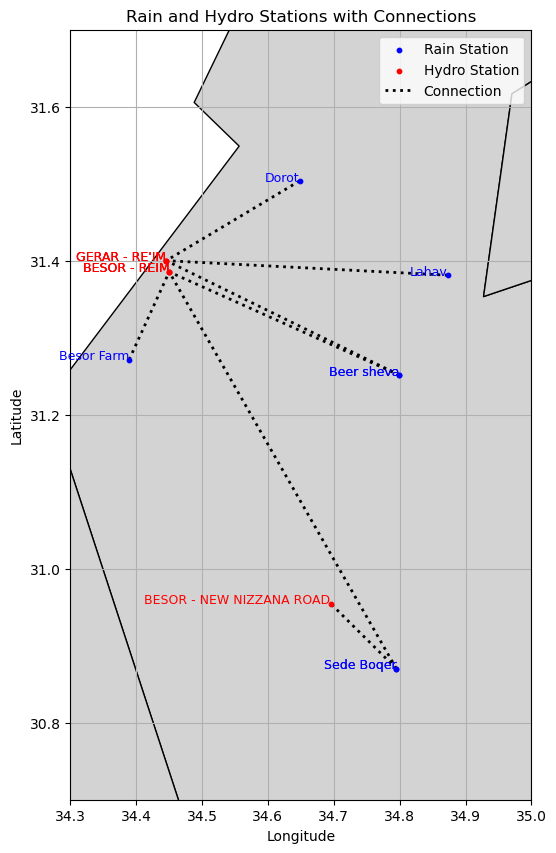

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import contextily as ctx

# Create GeoDataFrame for rain and hydro stations
gdf_rain = gpd.GeoDataFrame(rain_to_station_df, geometry=gpd.points_from_xy(rain_to_station_df.longtitude_rain, rain_to_station_df.latitude_rain), crs="EPSG:4326")
gdf_hydro = gpd.GeoDataFrame(rain_to_station_df, geometry=gpd.points_from_xy(rain_to_station_df.longtitude_hidro, rain_to_station_df.latitude_hidro), crs="EPSG:4326")

# Create GeoDataFrame for lines connecting the stations
lines = [LineString([(row['longtitude_rain'], row['latitude_rain']),
                     (row['longtitude_hidro'], row['latitude_hidro'])]) for idx, row in rain_to_station_df.iterrows()]
gdf_lines = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the world map as the background
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot rain and hydro stations
gdf_rain.plot(ax=ax, color='blue', label='Rain Station', markersize=10, zorder=3)
gdf_hydro.plot(ax=ax, color='red', label='Hydro Station', markersize=10, zorder=3)

# Plot lines connecting the stations
gdf_lines.plot(ax=ax, color='black', linewidth=2, linestyle='dotted', label='Connection', zorder=2)

# Add labels for the stations
for idx, row in rain_to_station_df.iterrows():
    plt.text(row['longtitude_rain'], row['latitude_rain'], row['rain_station'], fontsize=9, ha='right', color='blue', zorder=4)
    plt.text(row['longtitude_hidro'], row['latitude_hidro'], row['hidro_station_name'], fontsize=9, ha='right', color='red', zorder=4)

# Set plot limits to zoom in on Southern Israel
ax.set_xlim(34.3, 35.0)
ax.set_ylim(30.7, 31.7)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rain and Hydro Stations with Connections')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
# Save the graphs results
plot_model_results_F1(results_df_time_series_no_cv, 'F1_models_stations_time_series_no_cv')
plot_model_results_ROC_AUC(results_df_time_series_no_cv, 'AUC_models_stations_time_series_no_cv')
plot_model_average_results_ROC_AUC(results_df_time_series_no_cv, 'AUC_models_time_series_no_cv')
plot_model_average_results_F1_Score(results_df_time_series_no_cv,'F1_models_time_series_no_cv')

plot_model_results_F1(results_df_time_series_cv_features_selection, 'F1_models_stations_time_series_cv_selection')
plot_model_results_ROC_AUC(results_df_time_series_cv_features_selection, 'AUC_models_stations_time_series_cv_selection')
plot_model_average_results_ROC_AUC(results_df_time_series_cv_features_selection, 'AUC_models_time_series_cv_selection')
plot_model_average_results_F1_Score(results_df_time_series_cv_features_selection,'F1_models_time_series_cv_selection')

plot_model_results_F1(results_df_time_series_cv, 'F1_models_stations_time_series_cv')
plot_model_results_ROC_AUC(results_df_time_series_cv, 'AUC_models_stations_time_series_cv_selection')
plot_model_average_results_ROC_AUC(results_df_time_series_cv, 'AUC_models_time_series_cv_selection')
plot_model_average_results_F1_Score(results_df_time_series_cv,'F1_models_time_series_cv_selection')

In [ ]:
'''
import pandas as pd

no_cv = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_no_cv.csv")
#dummy = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_dummy.csv")
cv = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_grid_search.csv")
selection = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_cv_feature_selection.csv")
F_value = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_cv_feature_selection_Fvalue.csv")

def remove_train_columns(df):
    return df.loc[:, ~df.columns.str.contains('train')]

# Apply the function to each DataFrame
no_cv = remove_train_columns(no_cv).add_prefix('no_cv_')
#dummy = remove_train_columns(dummy).add_prefix('dummy_')
cv = remove_train_columns(cv).add_prefix('cv_')
selection = remove_train_columns(selection).add_prefix('mutual_')
F_value = remove_train_columns(F_value).add_prefix('F_VALUE_')
# Concatenate the data frames horizontally
#print(F_value)
combined_df = pd.concat([no_cv, cv, selection, F_value], axis=1)
combined_df.drop(['mutual_Model Name', 'cv_Model Name', 'F_VALUE_Model Name']
                  #'dummy_Model Name']
                  , inplace = True, axis = 1)
combined_df.rename(columns={'no_cv_Model Name': 'Model Name'}, inplace = True)

# Print the first few rows of the combined data frame to verify
print(combined_df)
'''

                       Model Name  no_cv_Accuracy_test  no_cv_Precision_test  \
0   Besor Farm_23150_RandomForest             0.952134              0.946483   
1       Besor Farm_23150_LightGBM             0.948991              0.938686   
2        Besor Farm_23150_XGBoost             0.949223              0.938775   
3        Dorot_23160_RandomForest             0.856043              0.859740   
4            Dorot_23160_LightGBM             0.845031              0.817757   
5             Dorot_23160_XGBoost             0.848653              0.823409   
6   Sede Boqer_23105_RandomForest             0.949325              0.951893   
7       Sede Boqer_23105_LightGBM             0.951530              0.943940   
8        Sede Boqer_23105_XGBoost             0.952479              0.944308   
9   Sede Boqer_23150_RandomForest             0.916559              0.859129   
10      Sede Boqer_23150_LightGBM             0.901262              0.863904   
11       Sede Boqer_23150_XGBoost       

In [ ]:
F1_scores = combined_df.filter(regex='F1|Model Name')
F1_scores

,Model Name,no_cv_F1 Score_test,cv_F1 Score_test,mutual_F1 Score_test,F_VALUE_F1 Score_test
0,Besor Farm_23150_RandomForest,0.938391,0.938391,0.937584,0.941786
1,Besor Farm_23150_LightGBM,0.940405,0.940405,0.943511,0.939686
2,Besor Farm_23150_XGBoost,0.940109,0.940109,0.945447,0.940958
3,Dorot_23160_RandomForest,0.811015,0.811015,0.803578,0.815791
4,Dorot_23160_LightGBM,0.817980,0.817980,0.809331,0.822025
5,Dorot_23160_XGBoost,0.816251,0.816251,0.809242,0.816617
6,Sede Boqer_23105_RandomForest,0.924781,0.924781,0.927491,0.925108
7,Sede Boqer_23105_LightGBM,0.931444,0.931444,0.934442,0.923714
8,Sede Boqer_23105_XGBoost,0.934339,0.934339,0.930491,0.925760
9,Sede Boqer_23150_RandomForest,0.886835,0.886835,0.884322,0.888042


In [ ]:
'''
import pandas as pd

no_cv = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_no_cv.csv")
#dummy = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_dummy.csv")
cv = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_grid_search.csv")
selection = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_cv_feature_selection.csv")
F_value = pd.read_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\classification_results_time_series_cv_feature_selection_Fvalue.csv")

def remove_train_columns(df):
    return df.loc[:, ~df.columns.str.contains('test')]

# Apply the function to each DataFrame
no_cv = remove_train_columns(no_cv).add_prefix('no_cv_')
#dummy = remove_train_columns(dummy).add_prefix('dummy_')
cv = remove_train_columns(cv).add_prefix('cv_')
selection = remove_train_columns(selection).add_prefix('mutual_')
F_value = remove_train_columns(F_value).add_prefix('F_VALUE_')
# Concatenate the data frames horizontally
#print(F_value)
combined_df = pd.concat([no_cv, cv, selection, F_value], axis=1)
combined_df.drop(['mutual_Model Name', 'cv_Model Name', 'F_VALUE_Model Name']
                  #'dummy_Model Name']
                  , inplace = True, axis = 1)
combined_df.rename(columns={'no_cv_Model Name': 'Model Name'}, inplace = True)

# Print the first few rows of the combined data frame to verify
print(combined_df)
'''

                       Model Name  no_cv_Accuracy_train  \
0   Besor Farm_23150_RandomForest              1.000000   
1       Besor Farm_23150_LightGBM              0.999825   
2        Besor Farm_23150_XGBoost              1.000000   
3        Dorot_23160_RandomForest              1.000000   
4            Dorot_23160_LightGBM              0.998945   
5             Dorot_23160_XGBoost              1.000000   
6   Sede Boqer_23105_RandomForest              1.000000   
7       Sede Boqer_23105_LightGBM              1.000000   
8        Sede Boqer_23105_XGBoost              1.000000   
9   Sede Boqer_23150_RandomForest              1.000000   
10      Sede Boqer_23150_LightGBM              0.999739   
11       Sede Boqer_23150_XGBoost              1.000000   
12  Beer sheva_23150_RandomForest              1.000000   
13      Beer sheva_23150_LightGBM              0.999831   
14       Beer sheva_23150_XGBoost              1.000000   
15  Beer sheva_23160_RandomForest              1.000000 

In [ ]:
'''
acc_scores = combined_df.filter(regex='Acc|Mode')
acc_scores
'''

,Model Name,no_cv_Accuracy_train,cv_Accuracy_train,mutual_Accuracy_train,F_VALUE_Accuracy_train
0,Besor Farm_23150_RandomForest,1.000000,1.000000,1.000000,1.000000
1,Besor Farm_23150_LightGBM,0.999825,0.999825,0.999612,0.999893
2,Besor Farm_23150_XGBoost,1.000000,1.000000,1.000000,0.999976
3,Dorot_23160_RandomForest,1.000000,1.000000,1.000000,1.000000
4,Dorot_23160_LightGBM,0.998945,0.998945,0.997122,0.996634
5,Dorot_23160_XGBoost,1.000000,1.000000,0.999973,0.999806
6,Sede Boqer_23105_RandomForest,1.000000,1.000000,1.000000,1.000000
7,Sede Boqer_23105_LightGBM,1.000000,1.000000,1.000000,0.999960
8,Sede Boqer_23105_XGBoost,1.000000,1.000000,1.000000,0.999980
9,Sede Boqer_23150_RandomForest,1.000000,1.000000,1.000000,1.000000
